# Who is an Attacker?

# Import Required Libraries

In [340]:
# Data Manipulation libraries:
import numpy as np
import pandas as pd
from copy import deepcopy

# Plotting libraries
import mplsoccer
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.projections import get_projection_class
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Load the Data

In [341]:
eventDataLL1920 = pd.read_csv("../data/matchwise_events_data_updated.csv",
                              low_memory=False)

In [342]:
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 100)

# Data Preparation

## Obtain Observations and Columns for Analysing Attackers

### Filtering based on Player Position

In [343]:
eventDataLL1920[["position.id", "position.name"]].drop_duplicates().sort_values("position.id")

position.id              position.name
33178          0.0                 Substitute
54             1.0                 Goalkeeper
40             2.0                 Right Back
22             3.0          Right Center Back
8169           4.0                Center Back
7              5.0           Left Center Back
30             6.0                  Left Back
8051           7.0            Right Wing Back
7978           8.0             Left Wing Back
4027           9.0   Right Defensive Midfield
5             10.0  Center Defensive Midfield
4063          11.0    Left Defensive Midfield
113           12.0             Right Midfield
33            13.0      Right Center Midfield
16            15.0       Left Center Midfield
39            16.0              Left Midfield
45            17.0                 Right Wing
11186         18.0   Right Attacking Midfield
3983          19.0  Center Attacking Midfield
11247         20.0    Left Attacking Midfield
66            21.0                  Left Wing
52            22.0       Right Center Forward
4             23.0             Center Forward
49            24.0        Left Center Forward
0              NaN                        NaN

In [344]:
eventDataLL1920[eventDataLL1920["position.id"] > 16]["position.name"].unique()

array(['Center Forward', 'Right Wing', 'Left Center Forward',
       'Right Center Forward', 'Left Wing', 'Center Attacking Midfield',
       'Right Attacking Midfield', 'Left Attacking Midfield'],
      dtype=object)

In [345]:
eventDataLL1920.shape

(129059, 155)

In [346]:
eventDataLL1920[eventDataLL1920["position.id"] > 16].shape

(29590, 155)

In [347]:
eventDataLL1920 = eventDataLL1920[eventDataLL1920["position.id"] > 16]

### Shot Columns

In [348]:
eventDataLL1920.columns[eventDataLL1920.columns.str.startswith("shot")]

Index(['shot.statsbomb_xg', 'shot.end_location', 'shot.key_pass_id',
       'shot.technique.id', 'shot.technique.name', 'shot.body_part.id',
       'shot.body_part.name', 'shot.type.id', 'shot.type.name',
       'shot.outcome.id', 'shot.outcome.name', 'shot.freeze_frame',
       'shot.first_time', 'shot.one_on_one', 'shot.redirect',
       'shot.aerial_won', 'shot.open_goal', 'shot.saved_to_post',
       'shot.deflected', 'shot.saved_off_target'],
      dtype='object')

In [349]:
shotCols = eventDataLL1920.columns[eventDataLL1920.columns.str.startswith("shot")]

In [350]:
shotCols

Index(['shot.statsbomb_xg', 'shot.end_location', 'shot.key_pass_id',
       'shot.technique.id', 'shot.technique.name', 'shot.body_part.id',
       'shot.body_part.name', 'shot.type.id', 'shot.type.name',
       'shot.outcome.id', 'shot.outcome.name', 'shot.freeze_frame',
       'shot.first_time', 'shot.one_on_one', 'shot.redirect',
       'shot.aerial_won', 'shot.open_goal', 'shot.saved_to_post',
       'shot.deflected', 'shot.saved_off_target'],
      dtype='object')

### Additional Columns

In [351]:
shotAdditionalCols = ['match_id', 'id',
                      'timestamp', 'minute', 'second',
                      'type.id', 'type.name',
                      'possession_team.id', 'possession_team.name',
                      'play_pattern.id', 'play_pattern.name',
                      'team.id', 'team.name',
                      'player.id', 'jersey_number', 'player.name',
                      'position.id', 'position.name',
                      'under_pressure', 'location',
                      'started', 'minsPlayed']

In [352]:
shotCols = shotCols.tolist()
shotCols = shotAdditionalCols + shotCols
shotCols

['match_id',
 'id',
 'timestamp',
 'minute',
 'second',
 'type.id',
 'type.name',
 'possession_team.id',
 'possession_team.name',
 'play_pattern.id',
 'play_pattern.name',
 'team.id',
 'team.name',
 'player.id',
 'jersey_number',
 'player.name',
 'position.id',
 'position.name',
 'under_pressure',
 'location',
 'started',
 'minsPlayed',
 'shot.statsbomb_xg',
 'shot.end_location',
 'shot.key_pass_id',
 'shot.technique.id',
 'shot.technique.name',
 'shot.body_part.id',
 'shot.body_part.name',
 'shot.type.id',
 'shot.type.name',
 'shot.outcome.id',
 'shot.outcome.name',
 'shot.freeze_frame',
 'shot.first_time',
 'shot.one_on_one',
 'shot.redirect',
 'shot.aerial_won',
 'shot.open_goal',
 'shot.saved_to_post',
 'shot.deflected',
 'shot.saved_off_target']

## Identifying Additional Attacker Metric Columns

In [353]:
eventDataLL1920.columns.values

array(['match_id', 'id', 'index', 'period', 'timestamp', 'minute',
       'second', 'possession', 'duration', 'type.id', 'type.name',
       'possession_team.id', 'possession_team.name', 'play_pattern.id',
       'play_pattern.name', 'team.id', 'team.name', 'tactics.formation',
       'tactics.lineup', 'related_events', 'off_camera', 'location',
       'player.id', 'player.name', 'position.id', 'position.name',
       'pass.recipient.id', 'pass.recipient.name', 'pass.length',
       'pass.angle', 'pass.height.id', 'pass.height.name',
       'pass.end_location', 'pass.body_part.id', 'pass.body_part.name',
       'pass.type.id', 'pass.type.name', 'carry.end_location',
       'under_pressure', 'dribble.outcome.id', 'dribble.outcome.name',
       'dribble.nutmeg', 'duel.type.id', 'duel.type.name',
       'duel.outcome.id', 'duel.outcome.name', 'pass.outcome.id',
       'pass.outcome.name', 'ball_receipt.outcome.id',
       'ball_receipt.outcome.name', 'counterpress',
       'ball_recovery.

In [354]:
eventDataLL1920[eventDataLL1920["type.id"] == 43]["carry.end_location"].isnull().sum()

0

In [355]:
eventDataLL1920[eventDataLL1920["type.id"] == 14]["dribble.outcome.name"].unique()

array(['Complete', 'Incomplete'], dtype=object)

In [356]:
eventDataLL1920[eventDataLL1920["type.id"] == 4]["duel.type.name"].unique()

array(['Aerial Lost', 'Tackle'], dtype=object)

In [357]:
eventDataLL1920[eventDataLL1920["type.id"] == 42]["ball_receipt.outcome.name"].unique()

array([nan, 'Incomplete'], dtype=object)

In [358]:
attAdditionalCols = ["pass.shot_assist", "pass.goal_assist",
                     "carry.end_location", "dribble.outcome.id", "dribble.outcome.name"]

Four types of events to consider to obtain and prepare attacking event data:
1. Shot
1. Carry: Final 3rd
1. Dribble: Final 3rd
1. Pass: Shot and Goal Assists

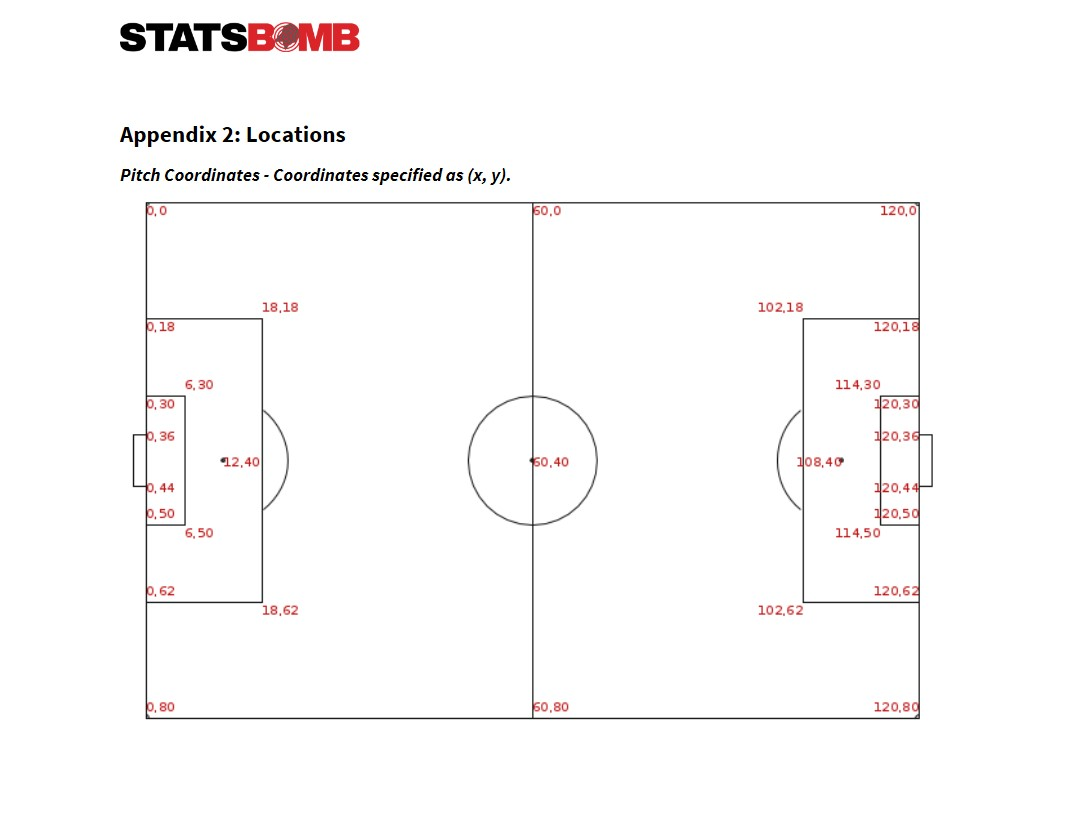

In [359]:
from IPython.display import Image
Image("../pics/SB_Field_Coords.jpg")

In [360]:
eventDataLL1920["shot.end_location"].unique()

array([nan, '[120.0, 45.4, 0.7]', '[120.0, 36.2, 1.9]',
       '[118.2, 37.2, 1.2]', '[120.0, 43.1, 4.6]', '[120.0, 43.1, 0.4]',
       '[108.2, 37.5, 0.2]', '[120.0, 36.8, 0.2]', '[94.6, 32.7]',
       '[120.0, 36.7, 0.6]', '[120.0, 45.4, 0.2]', '[120.0, 42.1, 0.8]',
       '[120.0, 45.1, 0.6]', '[120.0, 46.2, 1.2]', '[119.1, 43.8]',
       '[120.0, 44.7, 0.2]', '[116.4, 41.0, 2.3]', '[106.8, 51.2]',
       '[120.0, 44.5, 0.3]', '[115.9, 40.1, 0.0]', '[120.0, 27.6, 0.2]',
       '[108.8, 45.0]', '[104.9, 40.6]', '[120.0, 34.5, 4.2]',
       '[111.8, 30.7, 1.3]', '[120.0, 44.0, 3.7]', '[108.5, 31.2]',
       '[120.0, 32.6, 0.4]', '[98.8, 40.5]', '[103.0, 37.5]',
       '[120.0, 44.3, 0.4]', '[104.5, 50.3]', '[111.2, 32.4]',
       '[107.1, 47.0]', '[102.9, 37.4]', '[116.6, 43.8, 1.1]',
       '[120.0, 43.1, 1.9]', '[105.3, 33.4]', '[113.3, 49.8]',
       '[108.0, 37.3]', '[109.5, 44.1]', '[120.0, 35.3, 3.8]',
       '[120.0, 41.2, 0.2]', '[120.0, 43.8, 4.3]', '[120.0, 35.1, 1.4]',
    

In [ ]:
shotsDataLL1920["shot.end_location"]\
    .str.split(", ", expand=True)

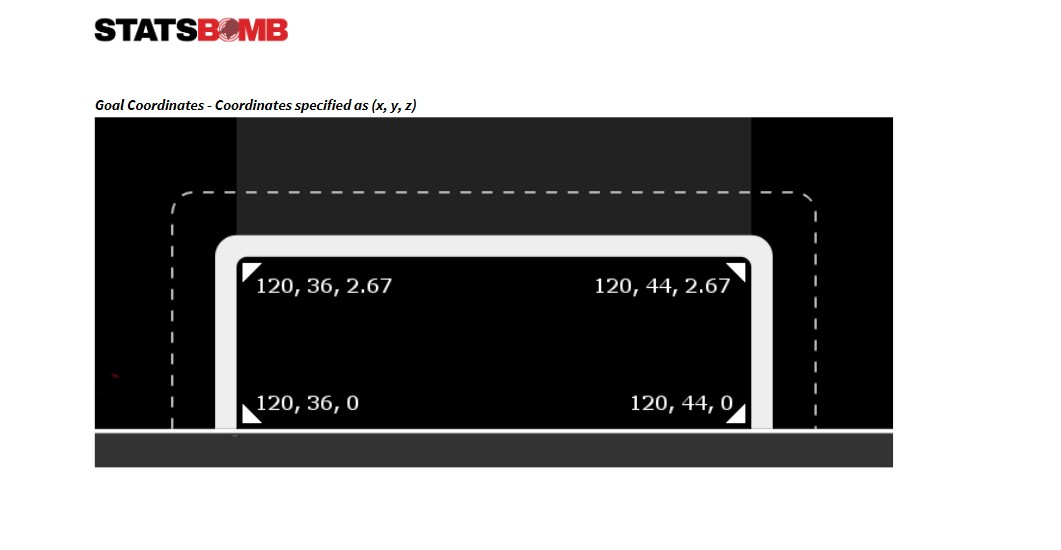

In [361]:
from IPython.display import Image
Image("../pics/SB_Goal_Height.jpg")

In [370]:
"""
If we have to slice only final 3rd values for carry and dribble,
we would need to separate out the X and Y coordinates
"""
# Start location for any action:
eventDataLL1920["startX"] = eventDataLL1920["location"]\
    .str.split(", ", expand=True)[0].str[1:].apply(pd.to_numeric)
eventDataLL1920["startY"] = eventDataLL1920["location"]\
    .str.split(", ", expand=True)[1].str[:-1].apply(pd.to_numeric)

# End location for carry:
eventDataLL1920["endXCarry"] = eventDataLL1920["carry.end_location"]\
    .str.split(", ", expand=True)[0].str[1:].apply(pd.to_numeric)
eventDataLL1920["endYCarry"] = eventDataLL1920["carry.end_location"]\
    .str.split(", ", expand=True)[1].str[:-1].apply(pd.to_numeric)

# End location for shots:
eventDataLL1920["endXShot"] = eventDataLL1920["shot.end_location"]\
    .str.split(", ", expand=True)[0].str[1:].apply(pd.to_numeric)
eventDataLL1920["endYShot"] = eventDataLL1920["shot.end_location"]\
    .str.split(", ", expand=True)[1].str.replace("]", "").apply(pd.to_numeric)
eventDataLL1920["goalHeight"] = eventDataLL1920["shot.end_location"]\
    .str.split(", ", expand=True)[2].str[:-1].apply(pd.to_numeric)

In [369]:
shotData["shot.end_location"]\
    .str.split(", ", expand=True)[1].str.replace("]", "")

471       45.4
759       36.2
779       37.2
940       43.1
1069      43.1
          ... 
128414    32.1
128499    47.6
128515    38.2
128861    37.6
128923    34.4
Name: 1, Length: 475, dtype: object

In [371]:
attAdditionalCols + ["startX", "startY", "endXCarry", "endYCarry", "endXShot", "endYShot", "goalHeight"]

['pass.shot_assist',
 'pass.goal_assist',
 'carry.end_location',
 'dribble.outcome.id',
 'dribble.outcome.name',
 'startX',
 'startY',
 'endXCarry',
 'endYCarry',
 'endXShot',
 'endYShot',
 'goalHeight']

In [372]:
attAdditionalCols = attAdditionalCols + ["startX", "startY", "endXCarry", "endYCarry",
                                         "endXShot", "endYShot", "goalHeight"]

In [373]:
attAdditionalCols

['pass.shot_assist',
 'pass.goal_assist',
 'carry.end_location',
 'dribble.outcome.id',
 'dribble.outcome.name',
 'startX',
 'startY',
 'endXCarry',
 'endYCarry',
 'endXShot',
 'endYShot',
 'goalHeight']

#### Condition 1: Shots

In [374]:
eventDataLL1920[eventDataLL1920["type.id"] == 16]["type.name"].unique()

array(['Shot'], dtype=object)

In [375]:
shotData = deepcopy(eventDataLL1920[eventDataLL1920["type.id"] == 16])

#### Condition 2: Carry Final 3rd

In [377]:
eventDataLL1920[(eventDataLL1920["type.id"] == 43)
                & (eventDataLL1920["startX"] > 80)]["type.name"].unique()

array(['Carry'], dtype=object)

In [394]:
carryData = deepcopy(eventDataLL1920[(eventDataLL1920["type.id"] == 43)
                            & (eventDataLL1920["startX"] > 80)])

#### Condition 3: Dribble Final 3rd

In [ ]:
eventDataLL1920["startXDribble"] = np.where(eventDataLL1920["type.id"] == 14, eventDataLL1920["startX"], np.nan)

In [380]:
eventDataLL1920[(eventDataLL1920["type.id"] == 14)
                & (eventDataLL1920["startX"] > 80)]["startX"].min()

80.2

In [381]:
dribbleData = deepcopy(eventDataLL1920[(eventDataLL1920["type.id"] == 14)
                              & (eventDataLL1920["startX"] > 80)])

#### Condition 4: Shot and Goal Assists

In [382]:
eventDataLL1920["pass.shot_assist"].unique()

array([nan, True], dtype=object)

In [383]:
eventDataLL1920[(eventDataLL1920["pass.shot_assist"])
                | (eventDataLL1920["pass.goal_assist"])]["type.name"].unique()

array(['Pass'], dtype=object)

In [384]:
eventDataLL1920[(eventDataLL1920["pass.shot_assist"])
                | (eventDataLL1920["pass.goal_assist"])]["play_pattern.name"].unique()

array(['From Free Kick', 'From Goal Kick', 'Regular Play',
       'From Throw In', 'From Keeper', 'From Corner', 'From Counter',
       'From Kick Off', 'Other'], dtype=object)

In [385]:
eventDataLL1920[((eventDataLL1920["pass.shot_assist"])
                | (eventDataLL1920["pass.goal_assist"]))
                & (eventDataLL1920["play_pattern.name"] == "From Kick Off")][["pass.shot_assist", "pass.goal_assist"]]

pass.shot_assist pass.goal_assist
11609             True              NaN
27524             True              NaN
29695             True              NaN
48916             True              NaN

In [386]:
assistData = deepcopy(eventDataLL1920[(eventDataLL1920["pass.shot_assist"])
                             | (eventDataLL1920["pass.goal_assist"])])

## Final Event Data for Analysing Attackers

In [395]:
type(carryData)

pandas.core.frame.DataFrame

In [396]:
pd.concat([shotData, carryData, dribbleData, assistData])

match_id                                    id  index  period  \
471       303421  0d426501-d17e-4dd8-abd0-e3f039a1738e    472       1   
759       303421  2c6cab4a-8c41-4356-a28e-2dc55efb10fa    760       1   
779       303421  2631da71-a158-4c7d-82ab-2425806763fd    780       1   
940       303421  09dd70ba-bc95-413e-92e1-020d666fc6b0    941       1   
1069      303421  0d285dcc-7406-4f5a-a358-a24d69ab501a   1070       1   
...          ...                                   ...    ...     ...   
124239    303682  8e6ae556-3281-44a8-82a3-47189c129640   2893       2   
125116    303682  3c750e29-09d3-4855-a093-2952feb2c5e3   3770       2   
125867    303731  9775a356-2281-43fd-af97-14ae1dc7ceb4    499       1   
127228    303731  c914e441-616a-4142-806c-fa34b9f1e311   1860       1   
127576    303731  d16736a1-6ed2-4d3b-b71c-0e7fb0ea5597   2208       2   

       timestamp  minute  second  possession  duration  type.id type.name  \
471      09:00.4       9       0          14  1.425280       16      Shot   
759      15:16.5      15      16          28  0.936023       16      Shot   
779      16:07.9      16       7          30  0.503484       16      Shot   
940      20:42.4      20      42          38  1.338275       16      Shot   
1069     23:29.3      23      29          43  0.466431       16      Shot   
...          ...     ...     ...         ...       ...      ...       ...   
124239   20:54.4      65      54         131  1.210272       30      Pass   
125116   42:15.6      87      15         181  1.337030       30      Pass   
125867   10:05.5      10       5          17  2.028036       30      Pass   
127228   42:53.6      42      53          82  0.782046       30      Pass   
127576   05:31.8      50      31          99  1.878801       30      Pass   

        possession_team.id possession_team.name  play_pattern.id  \
471                    217            Barcelona                7   
759                    217            Barcelona                1   
779                    217            Barcelona                1   
940                    217            Barcelona                3   
1069                   217            Barcelona                4   
...                    ...                  ...              ...   
124239                 221              Levante                1   
125116                 217            Barcelona                7   
125867                 322                Eibar                4   
127228                 217            Barcelona                1   
127576                 217            Barcelona                3   

       play_pattern.name  team.id  team.name  tactics.formation  \
471       From Goal Kick      217  Barcelona                NaN   
759         Regular Play      217  Barcelona                NaN   
779         Regular Play      217  Barcelona                NaN   
940       From Free Kick      217  Barcelona                NaN   
1069       From Throw In      217  Barcelona                NaN   
...                  ...      ...        ...                ...   
124239      Regular Play      221    Levante                NaN   
125116    From Goal Kick      217  Barcelona                NaN   
125867     From Throw In      322      Eibar                NaN   
127228      Regular Play      217  Barcelona                NaN   
127576    From Free Kick      217  Barcelona                NaN   

       tactics.lineup                                     related_events  \
471               NaN           ['4ce4e91f-a468-4ce1-a96b-9cb988ada664']   
759               NaN  ['86816c9e-eb56-4bf4-b16f-b986554d064a', '96c9...   
779               NaN           ['90373e3d-1e80-4a41-8390-dfd8e7efe9f6']   
940               NaN           ['d806859f-46b8-4f3c-8f3d-1dfd1dab6fd3']   
1069              NaN           ['24ebb3a0-38c0-4010-b9d3-027069e20bde']   
...               ...                                                ...   
124239            NaN           ['e51cd7e7-0ada-49e3

In [397]:
attEventData = pd.concat([shotData, carryData, dribbleData, assistData])

In [398]:
attEventData.sort_values(["match_id", "possession", "minute", "second"])

match_id                                    id  index  period  \
106117    303377  ff6d1b0e-01be-4db4-a9fd-c94eb4dd8526     69       1   
106126    303377  e30197bb-b47a-4a4c-9f5a-a54a17f5c7b7     78       1   
106194    303377  9c9c5bda-6fd8-4733-803a-18257c5526ea    146       1   
106196    303377  4da2e618-8ca6-42be-b2a1-e91265f8d5dd    148       1   
106297    303377  b697ff5f-0282-443e-9a81-92c8a01e14ef    249       1   
...          ...                                   ...    ...     ...   
128919    303731  7d49fce1-9fda-43ea-8e62-a00b98be59b4   3551       2   
128922    303731  8ab78e37-7bf4-4ea0-9957-360567c4a20f   3554       2   
128921    303731  7861c0f0-374d-4313-9bb3-b8e5aa5f6627   3553       2   
128923    303731  01b7fed8-2356-4480-8c1b-53ca8aea55a4   3555       2   
129035    303731  f6a1df48-be30-4f73-ab67-db7e43afdf57   3667       2   

       timestamp  minute  second  possession  duration  type.id type.name  \
106117   01:38.1       1      38           6  0.686003       43     Carry   
106126   01:44.3       1      44           6  0.897671       43     Carry   
106194   03:50.9       3      50          10  0.888555       43     Carry   
106196   03:51.8       3      51          10  0.000000       14   Dribble   
106297   05:46.4       5      46          14  2.813682       43     Carry   
...          ...     ...     ...         ...       ...      ...       ...   
128919   43:44.7      88      44         182  1.079621       43     Carry   
128922   43:45.8      88      45         182  1.003174       43     Carry   
128921   43:45.8      88      45         182  0.000000       14   Dribble   
128923   43:46.8      88      46         182  0.295647       16      Shot   
129035   46:42.9      91      42         184  0.254399       43     Carry   

        possession_team.id possession_team.name  play_pattern.id  \
106117                 216               Getafe                1   
106126                 216               Getafe                1   
106194                 216               Getafe                4   
106196                 216               Getafe                4   
106297                 217            Barcelona                4   
...                    ...                  ...              ...   
128919                 217            Barcelona                1   
128922                 217            Barcelona                1   
128921                 217            Barcelona                1   
128923                 217            Barcelona                1   
129035                 217            Barcelona                1   

       play_pattern.name  team.id  team.name  tactics.formation  \
106117      Regular Play      216     Getafe                NaN   
106126      Regular Play      216     Getafe                NaN   
106194     From Throw In      216     Getafe                NaN   
106196     From Throw In      216     Getafe                NaN   
106297     From Throw In      216     Getafe                NaN   
...                  ...      ...        ...                ...   
128919      Regular Play      217  Barcelona                NaN   
128922      Regular Play      217  Barcelona                NaN   
128921      Regular Play      217  Barcelona                NaN   
128923      Regular Play      217  Barcelona                NaN   
129035      Regular Play      217  Barcelona                NaN   

       tactics.lineup                                     related_events  \
106117            NaN  ['342ff133-0233-428c-830c-d0c598b86fd1', 'd740...   
106126            NaN  ['329dbd02-c255-4ea0-8fe7-862ee9d7ea9a', '6f67...   
106194            NaN  ['00d9df60-165c-4699-b668-0239fa4bc7c2', '058b...   
106196            NaN           ['00d9df60-165c-4699-b668-0239fa4bc7c2']   
106297            NaN  ['39459e20-1bbf-4e89-b041-6de0292a0de7', '3b99...   
...               ...                                                ...   
128919            NaN  ['46f6b464-d5eb-4a2e-b625-e03

In [399]:
attEventData.sort_values(["match_id", "possession", "minute", "second"], inplace=True)

In [400]:
attFinalCols = shotCols + attAdditionalCols

In [401]:
attEventData[attFinalCols]["type.name"].unique()

array(['Carry', 'Dribble', 'Shot', 'Pass'], dtype=object)

In [402]:
attEventData = attEventData[attFinalCols]

In [403]:
attEventData.shape

(4090, 54)

# Exploring Attacking Metrics

In [733]:
attEventData.head()

match_id                                    id timestamp  minute  \
106117    303377  ff6d1b0e-01be-4db4-a9fd-c94eb4dd8526   01:38.1       1   
106126    303377  e30197bb-b47a-4a4c-9f5a-a54a17f5c7b7   01:44.3       1   
106194    303377  9c9c5bda-6fd8-4733-803a-18257c5526ea   03:50.9       3   
106196    303377  4da2e618-8ca6-42be-b2a1-e91265f8d5dd   03:51.8       3   
106297    303377  b697ff5f-0282-443e-9a81-92c8a01e14ef   05:46.4       5   

        second  type.id type.name  possession_team.id possession_team.name  \
106117      38       43     Carry                 216               Getafe   
106126      44       43     Carry                 216               Getafe   
106194      50       43     Carry                 216               Getafe   
106196      51       14   Dribble                 216               Getafe   
106297      46       43     Carry                 217            Barcelona   

        play_pattern.id play_pattern.name  team.id team.name  player.id  \
106117                1      Regular Play      216    Getafe    11550.0   
106126                1      Regular Play      216    Getafe    11550.0   
106194                4     From Throw In      216    Getafe     6630.0   
106196                4     From Throw In      216    Getafe     6630.0   
106297                4     From Throw In      216    Getafe     6630.0   

        jersey_number         player.name  position.id         position.name  \
106117            7.0   Jaime Mata Arnaiz         24.0   Left Center Forward   
106126            7.0   Jaime Mata Arnaiz         24.0   Left Center Forward   
106194           19.0  Jorge Molina Vidal         22.0  Right Center Forward   
106196           19.0  Jorge Molina Vidal         22.0  Right Center Forward   
106297           19.0  Jorge Molina Vidal         22.0  Right Center Forward   

       under_pressure       location started  minsPlayed  shot.statsbomb_xg  \
106117            NaN   [89.2, 34.5]     Yes        93.0                NaN   
106126           True  [115.9, 21.0]     Yes        93.0                NaN   
106194           True   [90.8, 72.0]     Yes        51.0                NaN   
106196           True   [90.6, 67.7]     Yes        51.0                NaN   
106297           True   [98.1, 70.1]     Yes        51.0                NaN   

       shot.end_location shot.key_pass_id  ...  shot.type.id shot.type.name  \
106117               NaN              NaN  ...           NaN            NaN   
106126               NaN              NaN  ...           NaN            NaN   
106194               NaN              NaN  ...           NaN            NaN   
106196               NaN              NaN  ...           NaN            NaN   
106297               NaN              NaN  ...           NaN            NaN   

        shot.outcome.id shot.outcome.name  shot.freeze_frame shot.first_time  \
106117              NaN               NaN                NaN             NaN   
106126              NaN               NaN                NaN             NaN   
106194              NaN               NaN                NaN             NaN   
106196              NaN               NaN                NaN             NaN   
106297              NaN               NaN                NaN             NaN   

        shot.one_on_one shot.redirect shot.aerial_won shot.open_goal  \
106117              NaN           NaN             NaN            NaN   
106126              NaN           NaN             NaN            NaN   
106194              NaN           NaN             NaN            NaN   
106196              NaN           NaN             NaN            NaN   
106297              NaN           NaN             NaN            NaN   

       shot.saved_to_post shot.deflected shot.saved_off_target  \
106117                NaN            NaN                   NaN   
106126                NaN            NaN                   NaN   
106194                NaN            NaN                   NaN   
106196                

## Meta Level Exploration

In [734]:
attEventData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4090 entries, 106117 to 129035
Data columns (total 54 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   match_id               4090 non-null   int64  
 1   id                     4090 non-null   object 
 2   timestamp              4090 non-null   object 
 3   minute                 4090 non-null   int64  
 4   second                 4090 non-null   int64  
 5   type.id                4090 non-null   int64  
 6   type.name              4090 non-null   object 
 7   possession_team.id     4090 non-null   int64  
 8   possession_team.name   4090 non-null   object 
 9   play_pattern.id        4090 non-null   int64  
 10  play_pattern.name      4090 non-null   object 
 11  team.id                4090 non-null   int64  
 12  team.name              4090 non-null   object 
 13  player.id              4090 non-null   float64
 14  jersey_number          3581 non-null   float64
 1

In [735]:
attEventData.describe().round(1)

match_id  minute  second  type.id  possession_team.id  play_pattern.id  \
count    4090.0  4090.0  4090.0   4090.0              4090.0           4090.0   
mean   303572.8    47.6    30.1     36.6               254.2              2.7   
std       103.6    26.7    17.2     11.3               162.2              2.0   
min    303377.0     0.0     0.0     14.0               205.0              1.0   
25%    303487.0    25.0    15.0     30.0               217.0              1.0   
50%    303596.0    47.0    30.0     43.0               217.0              2.0   
75%    303674.0    70.0    45.0     43.0               217.0              4.0   
max    303731.0    96.0    59.0     43.0              1049.0              9.0   

       team.id  player.id  jersey_number  position.id  minsPlayed  \
count   4090.0     4090.0         3581.0       4090.0      4090.0   
mean     254.8     9324.1           13.6         20.6        80.4   
std      163.5     8097.9            6.6          2.5        21.5   
min      205.0     3058.0            5.0         17.0         3.0   
25%      217.0     5487.0           10.0         17.0        70.0   
50%      217.0     5503.0           10.0         21.0        93.0   
75%      217.0     6766.0           17.0         23.0        94.0   
max     1049.0    40881.0           34.0         24.0        97.0   

       shot.statsbomb_xg  shot.technique.id  shot.body_part.id  shot.type.id  \
count              475.0              475.0              475.0         475.0   
mean                 0.1               92.8               38.7          84.5   
std                  0.2                0.8                1.8           7.5   
min                  0.0               89.0               37.0          62.0   
25%                  0.0               93.0               38.0          87.0   
50%                  0.1               93.0               38.0          87.0   
75%                  0.2               93.0               40.0          87.0   
max                  0.9               95.0               70.0          88.0   

       shot.outcome.id  dribble.outcome.id  startX  startY  endXCarry  \
count            475.0               367.0  4090.0  4090.0     3051.0   
mean              98.1                 8.4    96.2    39.3       96.5   
std                2.2                 0.5    10.1    21.3       10.1   
min               96.0                 8.0    43.3     0.1       64.1   
25%               96.0                 8.0    88.1    22.7       88.8   
50%               98.0                 8.0    95.5    39.1       95.8   
75%              100.0                 9.0   104.2    56.4      104.2   
max              115.0                 9.0   120.0    80.5      120.0   

       endYCarry  endXShot  endYShot  goalHeight  
count     3051.0     475.0     475.0       337.0  
mean        38.7     115.7      39.4         1.5  
std         21.4       6.2       6.4         1.6  
min          0.1      93.5       0.1         0.0  
25%         21.1     113.8      35.6         0.3  
50%         37.7     118.8      39.6         1.0  
75%         56.4     120.0      43.5         2.0  
max         80.0     120.0      76.5         7.4

In [739]:
attEventData.describe(include="object").round(1)

id timestamp type.name  \
count                                   4090      4090      4090   
unique                                  4090      3639         4   
top     8364b6c5-ab76-4d15-a64a-fa13b5fe1b42   36:32.9     Carry   
freq                                       1         4      3051   

       possession_team.name play_pattern.name  team.name  \
count                  4090              4090       4090   
unique                   20                 9         20   
top               Barcelona      Regular Play  Barcelona   
freq                   3001              1795       2992   

                           player.name position.name under_pressure  \
count                             4090          4090           1830   
unique                             115             8              1   
top     Lionel Andrés Messi Cuccittini    Right Wing           True   
freq                              1405          1097           1830   

             location started   shot.end_location  \
count            4090    3581                 475   
unique           3808       1                 468   
top     [120.0, 80.0]     Yes  [120.0, 44.7, 0.2]   
freq                6    3581                   3   

                            shot.key_pass_id shot.technique.name  \
count                                    362                 475   
unique                                   362                   6   
top     b79cc320-0eee-4e71-95c6-d42ac326d416              Normal   
freq                                       1                 395   

       shot.body_part.name shot.type.name shot.outcome.name  \
count                  475            475               475   
unique                   4              3                 7   
top              Left Foot      Open Play             Saved   
freq                   251            419               131   

                                        shot.freeze_frame shot.first_time  \
count                                                 470             125   
unique                                                470               1   
top     [{'location': [108.1, 38.0], 'player': {'id': ...            True   
freq                                                    1             125   

       shot.one_on_one shot.redirect shot.aerial_won shot.open_goal  \
count               49             1              10              7   
unique               1             1               1              1   
top               True          True            True           True   
freq                49             1              10              7   

       shot.saved_to_post shot.deflected shot.saved_off_target  \
count                   0              6                     4   
unique                  0              1                     1   
top                   NaN           True                  True   
freq                  NaN              6                     4   

       pass.shot_assist pass.goal_assist carry.end_location  \
count               197                0               3051   
unique                1                0               3032   
top                True              NaN       [84.7, 43.4]   
freq                197              NaN                  2   

       dribble.outcome.name  
count                   367  
unique                    2  
top                Complete  
freq                    218

In [740]:
attEventData.columns

Index(['match_id', 'id', 'timestamp', 'minute', 'second', 'type.id',
       'type.name', 'possession_team.id', 'possession_team.name',
       'play_pattern.id', 'play_pattern.name', 'team.id', 'team.name',
       'player.id', 'jersey_number', 'player.name', 'position.id',
       'position.name', 'under_pressure', 'location', 'started', 'minsPlayed',
       'shot.statsbomb_xg', 'shot.end_location', 'shot.key_pass_id',
       'shot.technique.id', 'shot.technique.name', 'shot.body_part.id',
       'shot.body_part.name', 'shot.type.id', 'shot.type.name',
       'shot.outcome.id', 'shot.outcome.name', 'shot.freeze_frame',
       'shot.first_time', 'shot.one_on_one', 'shot.redirect',
       'shot.aerial_won', 'shot.open_goal', 'shot.saved_to_post',
       'shot.deflected', 'shot.saved_off_target', 'pass.shot_assist',
       'pass.goal_assist', 'carry.end_location', 'dribble.outcome.id',
       'dribble.outcome.name', 'startX', 'startY', 'endXCarry', 'endYCarry',
       'endXShot', 'endYShot'

In [741]:
numCols = ['shot.statsbomb_xg']

In [742]:
px.histogram(data_frame=attEventData, x="shot.statsbomb_xg")

In [743]:
attEventData[["shot.outcome.id", "shot.outcome.name"]].drop_duplicates()

shot.outcome.id shot.outcome.name
106117              NaN               NaN
106570             96.0           Blocked
106699            100.0             Saved
107307             97.0              Goal
107579             98.0             Off T
22167             101.0           Wayward
759                99.0              Post
33324             115.0  Saved Off Target

In [744]:
px.histogram(data_frame=attEventData[attEventData["shot.outcome.id"] == 97],
             x="shot.statsbomb_xg")

In [745]:
px.histogram(data_frame=attEventData[attEventData["shot.outcome.id"] == 98],
             x="shot.statsbomb_xg", histnorm="percent")

In [ ]:
attEventData["shot.outcome.id"].dropna().unique()

In [ ]:
shotOutcomesList = attEventData["shot.outcome.id"].dropna().unique()

In [ ]:
shotOutcomeNamesList = attEventData["shot.outcome.name"].dropna().unique()

In [746]:
i = j = 1
# Create an empty subplot:
fig = make_subplots(rows=2, cols=4,
                    shared_xaxes=False,
                    vertical_spacing=0.1,
                    subplot_titles=shotOutcomeNamesList)
# Add bar plot for goals conceded in all subplots:
for idx in shotOutcomesList:
    plot_df = attEventData[attEventData["shot.outcome.id"] == idx]
    fig.add_trace(go.Histogram(x=plot_df["shot.statsbomb_xg"],
                               name=plot_df["shot.outcome.name"].unique().item()),
                  row=i, col=j)
    j += 1
    if j > 4:
        j = 1
        i += 1
# fig.update_traces(textposition='inside', textfont_size=30, textfont_color="white")
fig.update_layout(height=800)

fig.show()

In [747]:
shotTechniquesList = attEventData["shot.technique.id"].dropna().unique()
shotTechniqueNamesList = attEventData["shot.technique.name"].dropna().unique()

i = j = 1
# Create an empty subplot:
fig = make_subplots(rows=2, cols=4,
                    shared_xaxes=False,
                    vertical_spacing=0.1,
                    subplot_titles=shotTechniqueNamesList)
# Add bar plot for goals conceded in all subplots:
for idx in shotTechniquesList:
    plot_df = attEventData[attEventData["shot.technique.id"] == idx]
    fig.add_trace(go.Histogram(x=plot_df["shot.statsbomb_xg"],
                               name=plot_df["shot.technique.name"].unique().item(),
                              histnorm="percent"),
                  row=i, col=j)
    j += 1
    if j > 4:
        j = 1
        i += 1
# fig.update_traces(textposition='inside', textfont_size=30, textfont_color="white")
fig.update_layout(height=800)

fig.show()

In [ ]:
sum(attEventData["shot.technique.name"] == "Overhead Kick")

In [748]:
catCols = ['play_pattern.name', 'position.name', 'under_pressure', 'shot.technique.name',
          'shot.body_part.name', 'shot.type.name', 'shot.outcome.name', 'dribble.outcome.name']

In [749]:
i = j = 1
# Create an empty subplot:
fig = make_subplots(rows=4, cols=2,
                    shared_xaxes=False,
                    vertical_spacing=0.1,
                    subplot_titles=catCols)
# Add bar plot for goals conceded in all subplots:
for col in catCols:
    plot_df = attEventData[col].value_counts().reset_index()
    fig.add_trace(go.Bar(x=plot_df["index"],
                         y=plot_df[col],
                         text=plot_df[col],
                         name=col),
                  row=i, col=j)
    j += 1
    if j > 2:
        j = 1
        i += 1
fig.update_traces(textposition='inside', textfont_size=10)
fig.update_layout(height=1600)

fig.show()

## Shot Heat Maps

### Overall

In [750]:
pitch = mplsoccer.VerticalPitch(line_color='#000009', line_zorder=2, pitch_color='white')
fig, ax = pitch.draw(figsize=(6, 8))
hexmap = pitch.hexbin(shotData["startX"], shotData["startY"],
                      ax=ax, edgecolors='#f4f4f4',
                      gridsize=(5, 5), cmap="Reds")

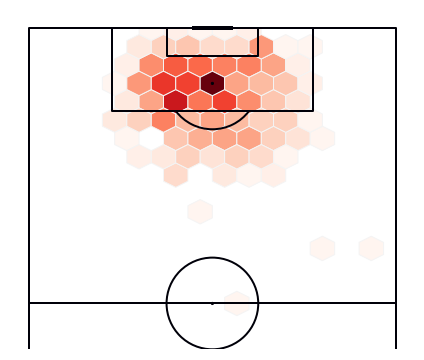

In [757]:
pitch = mplsoccer.VerticalPitch(line_color='#000009', line_zorder=2, pitch_color='white', half=True,
                            pad_bottom=10)
fig, ax = pitch.draw(figsize=(6, 8))
hexmap = pitch.hexbin(shotData["startX"], shotData["startY"],
                      ax=ax, edgecolors='#f4f4f4',
                      gridsize=(15, 15), cmap="Reds")

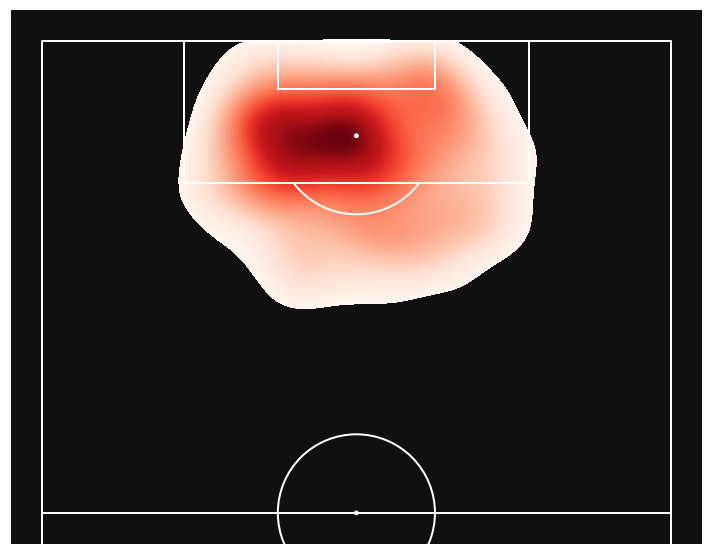

In [756]:
pitch_dark = mplsoccer.VerticalPitch(line_color='white', line_zorder=2, pitch_color='#101010', half=True)
fig, ax = pitch_dark.draw(figsize=(10, 14))
kdeplot_dark = pitch_dark.kdeplot(shotData["startX"], shotData["startY"],
                                  ax=ax, shade=True, levels=100, cmap="Reds")

### Team-wise

In [758]:
shotData["team.id"].nunique()

20

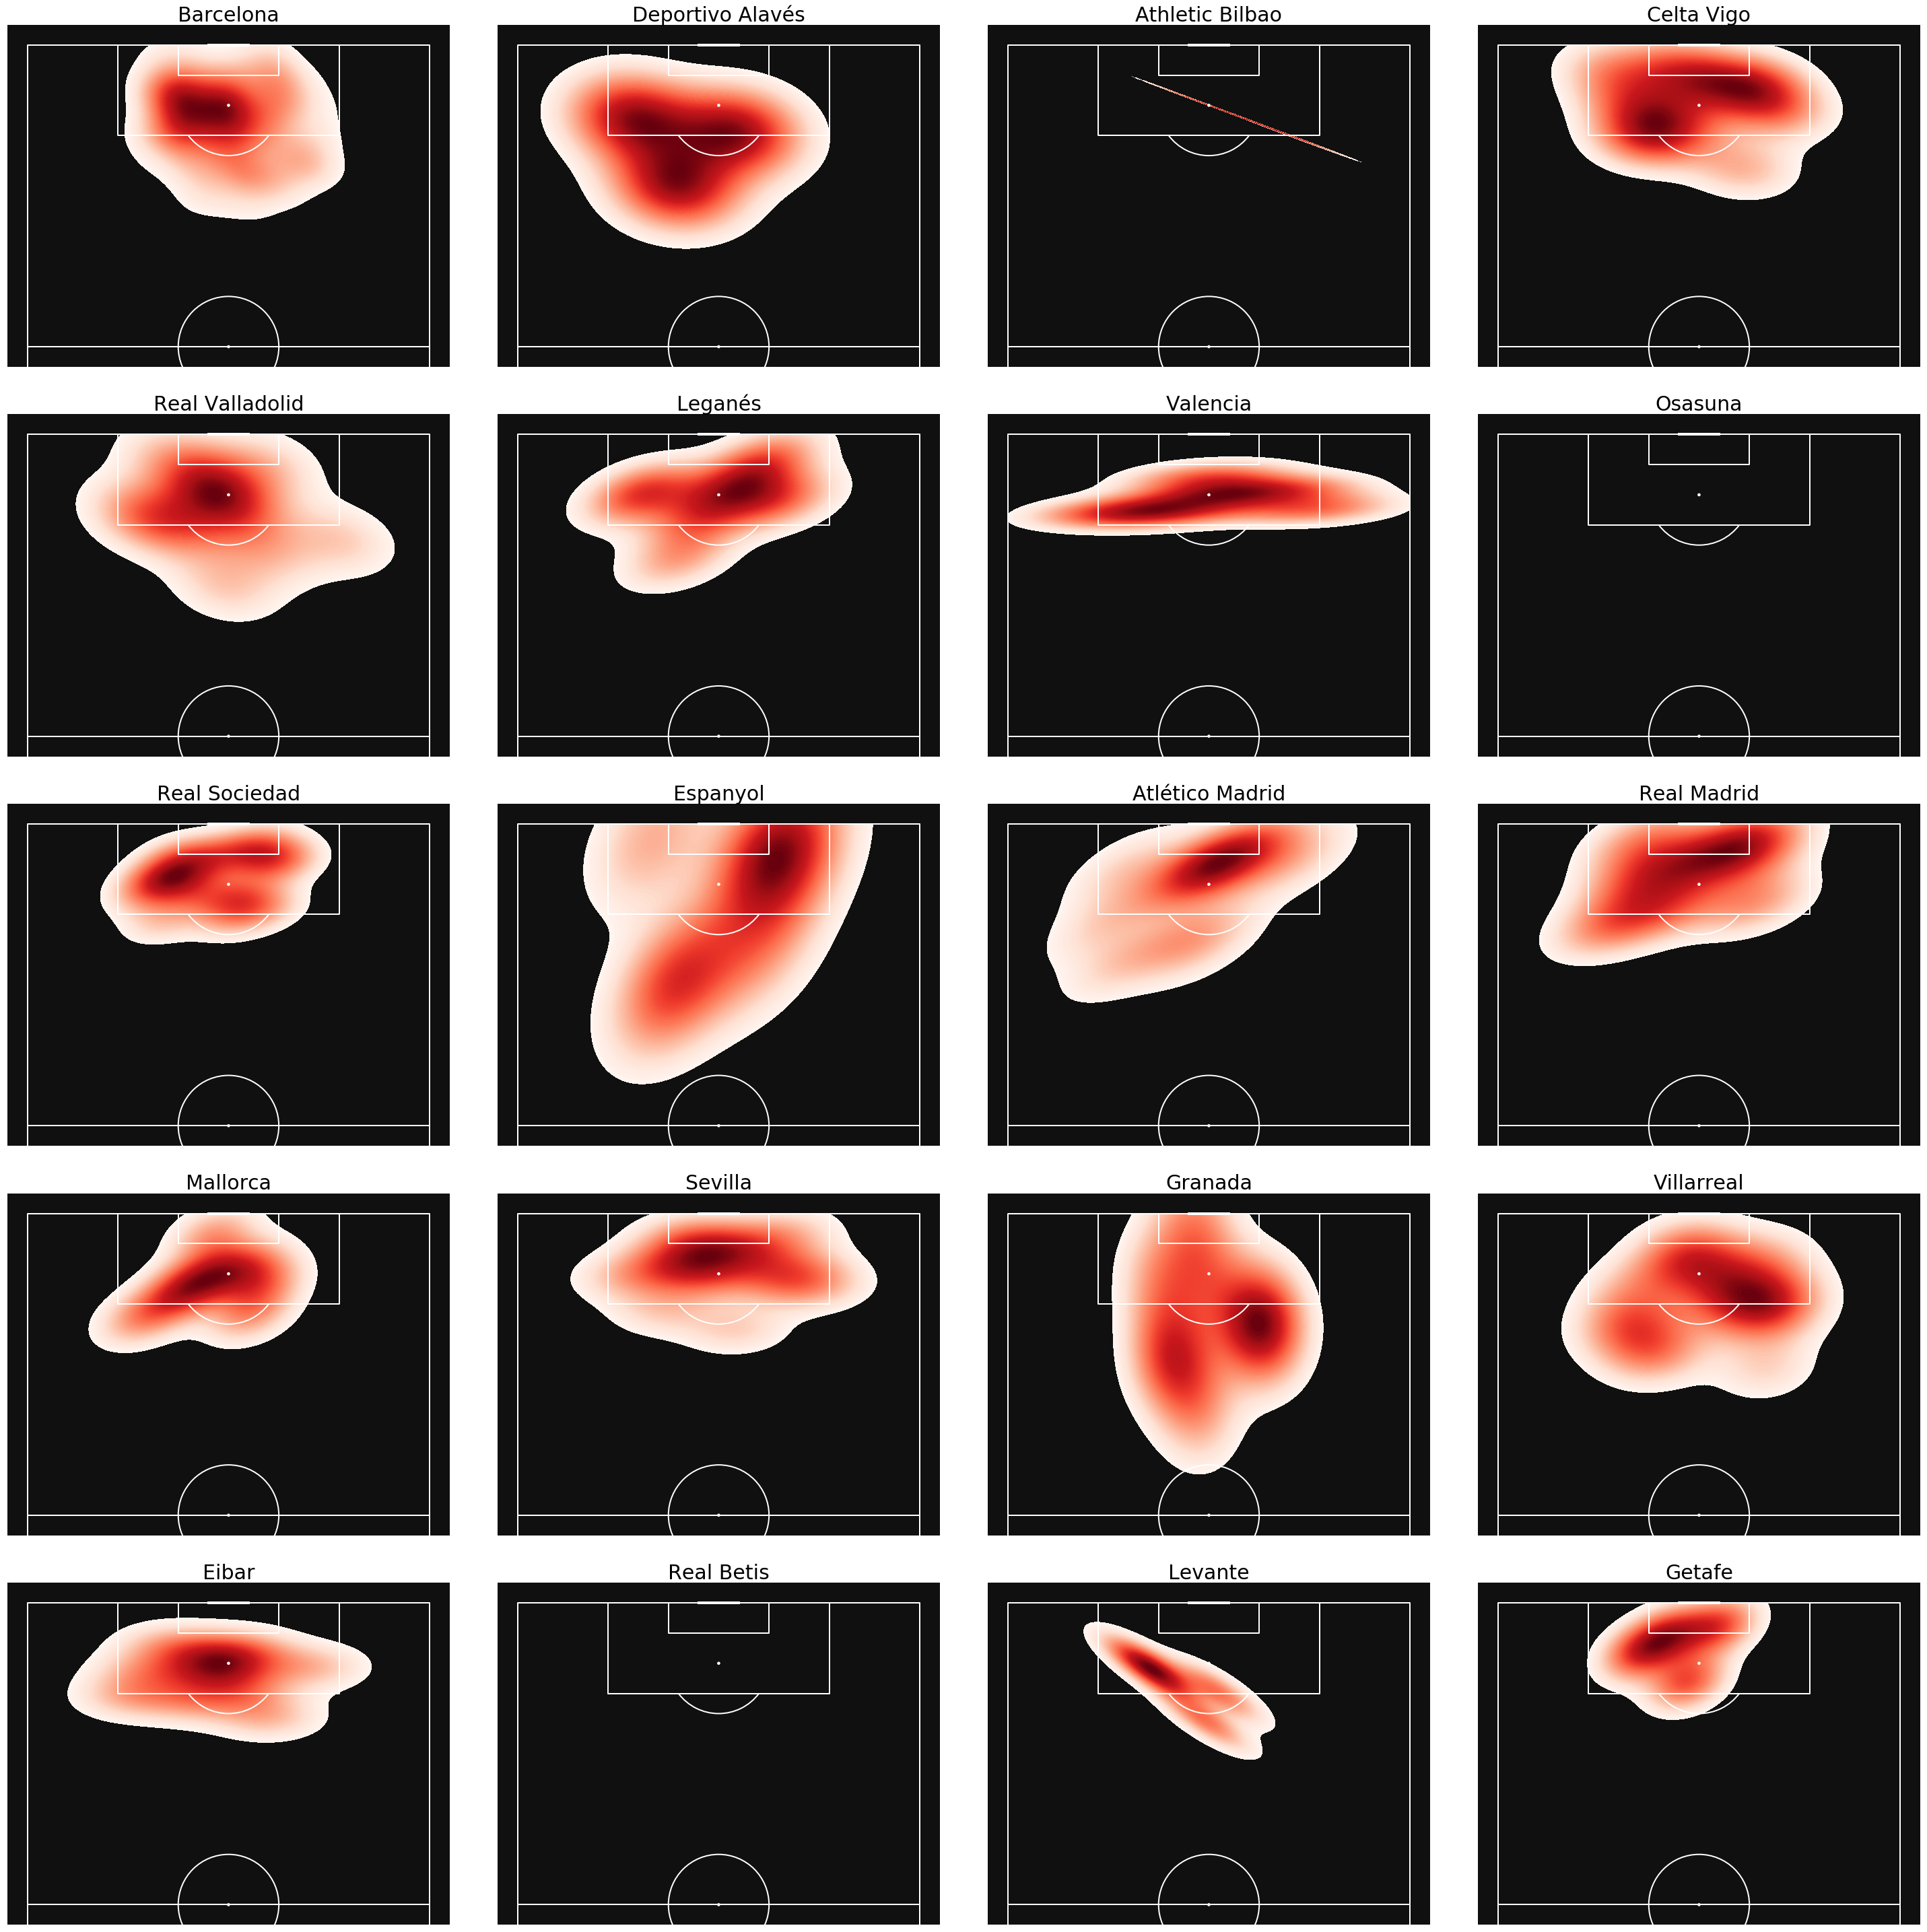

In [759]:
pitch = mplsoccer.VerticalPitch(line_color='white', line_zorder=2, pitch_color='#101010', half=True)
fig, axs = pitch.grid(nrows=5, ncols=4, space=0.1, figheight=40,
                      title_height=0, endnote_height=0,  # no title/ endnote
                      grid_width=0.9, grid_height=0.98, bottom=0.01, left=0.05)
teamIDs = shotData["possession_team.id"].unique()
for idx, ax in enumerate(axs['pitch'].flat):
    teamShotsData = shotData[shotData["possession_team.id"] == teamIDs[idx]]
    kdeplot_dark = pitch_dark.kdeplot(teamShotsData["startX"], teamShotsData["startY"],
                                      ax=ax, shade=True, levels=100, cmap="Reds")
    ax.set_title(teamShotsData["possession_team.name"].unique().item(), fontsize=30)

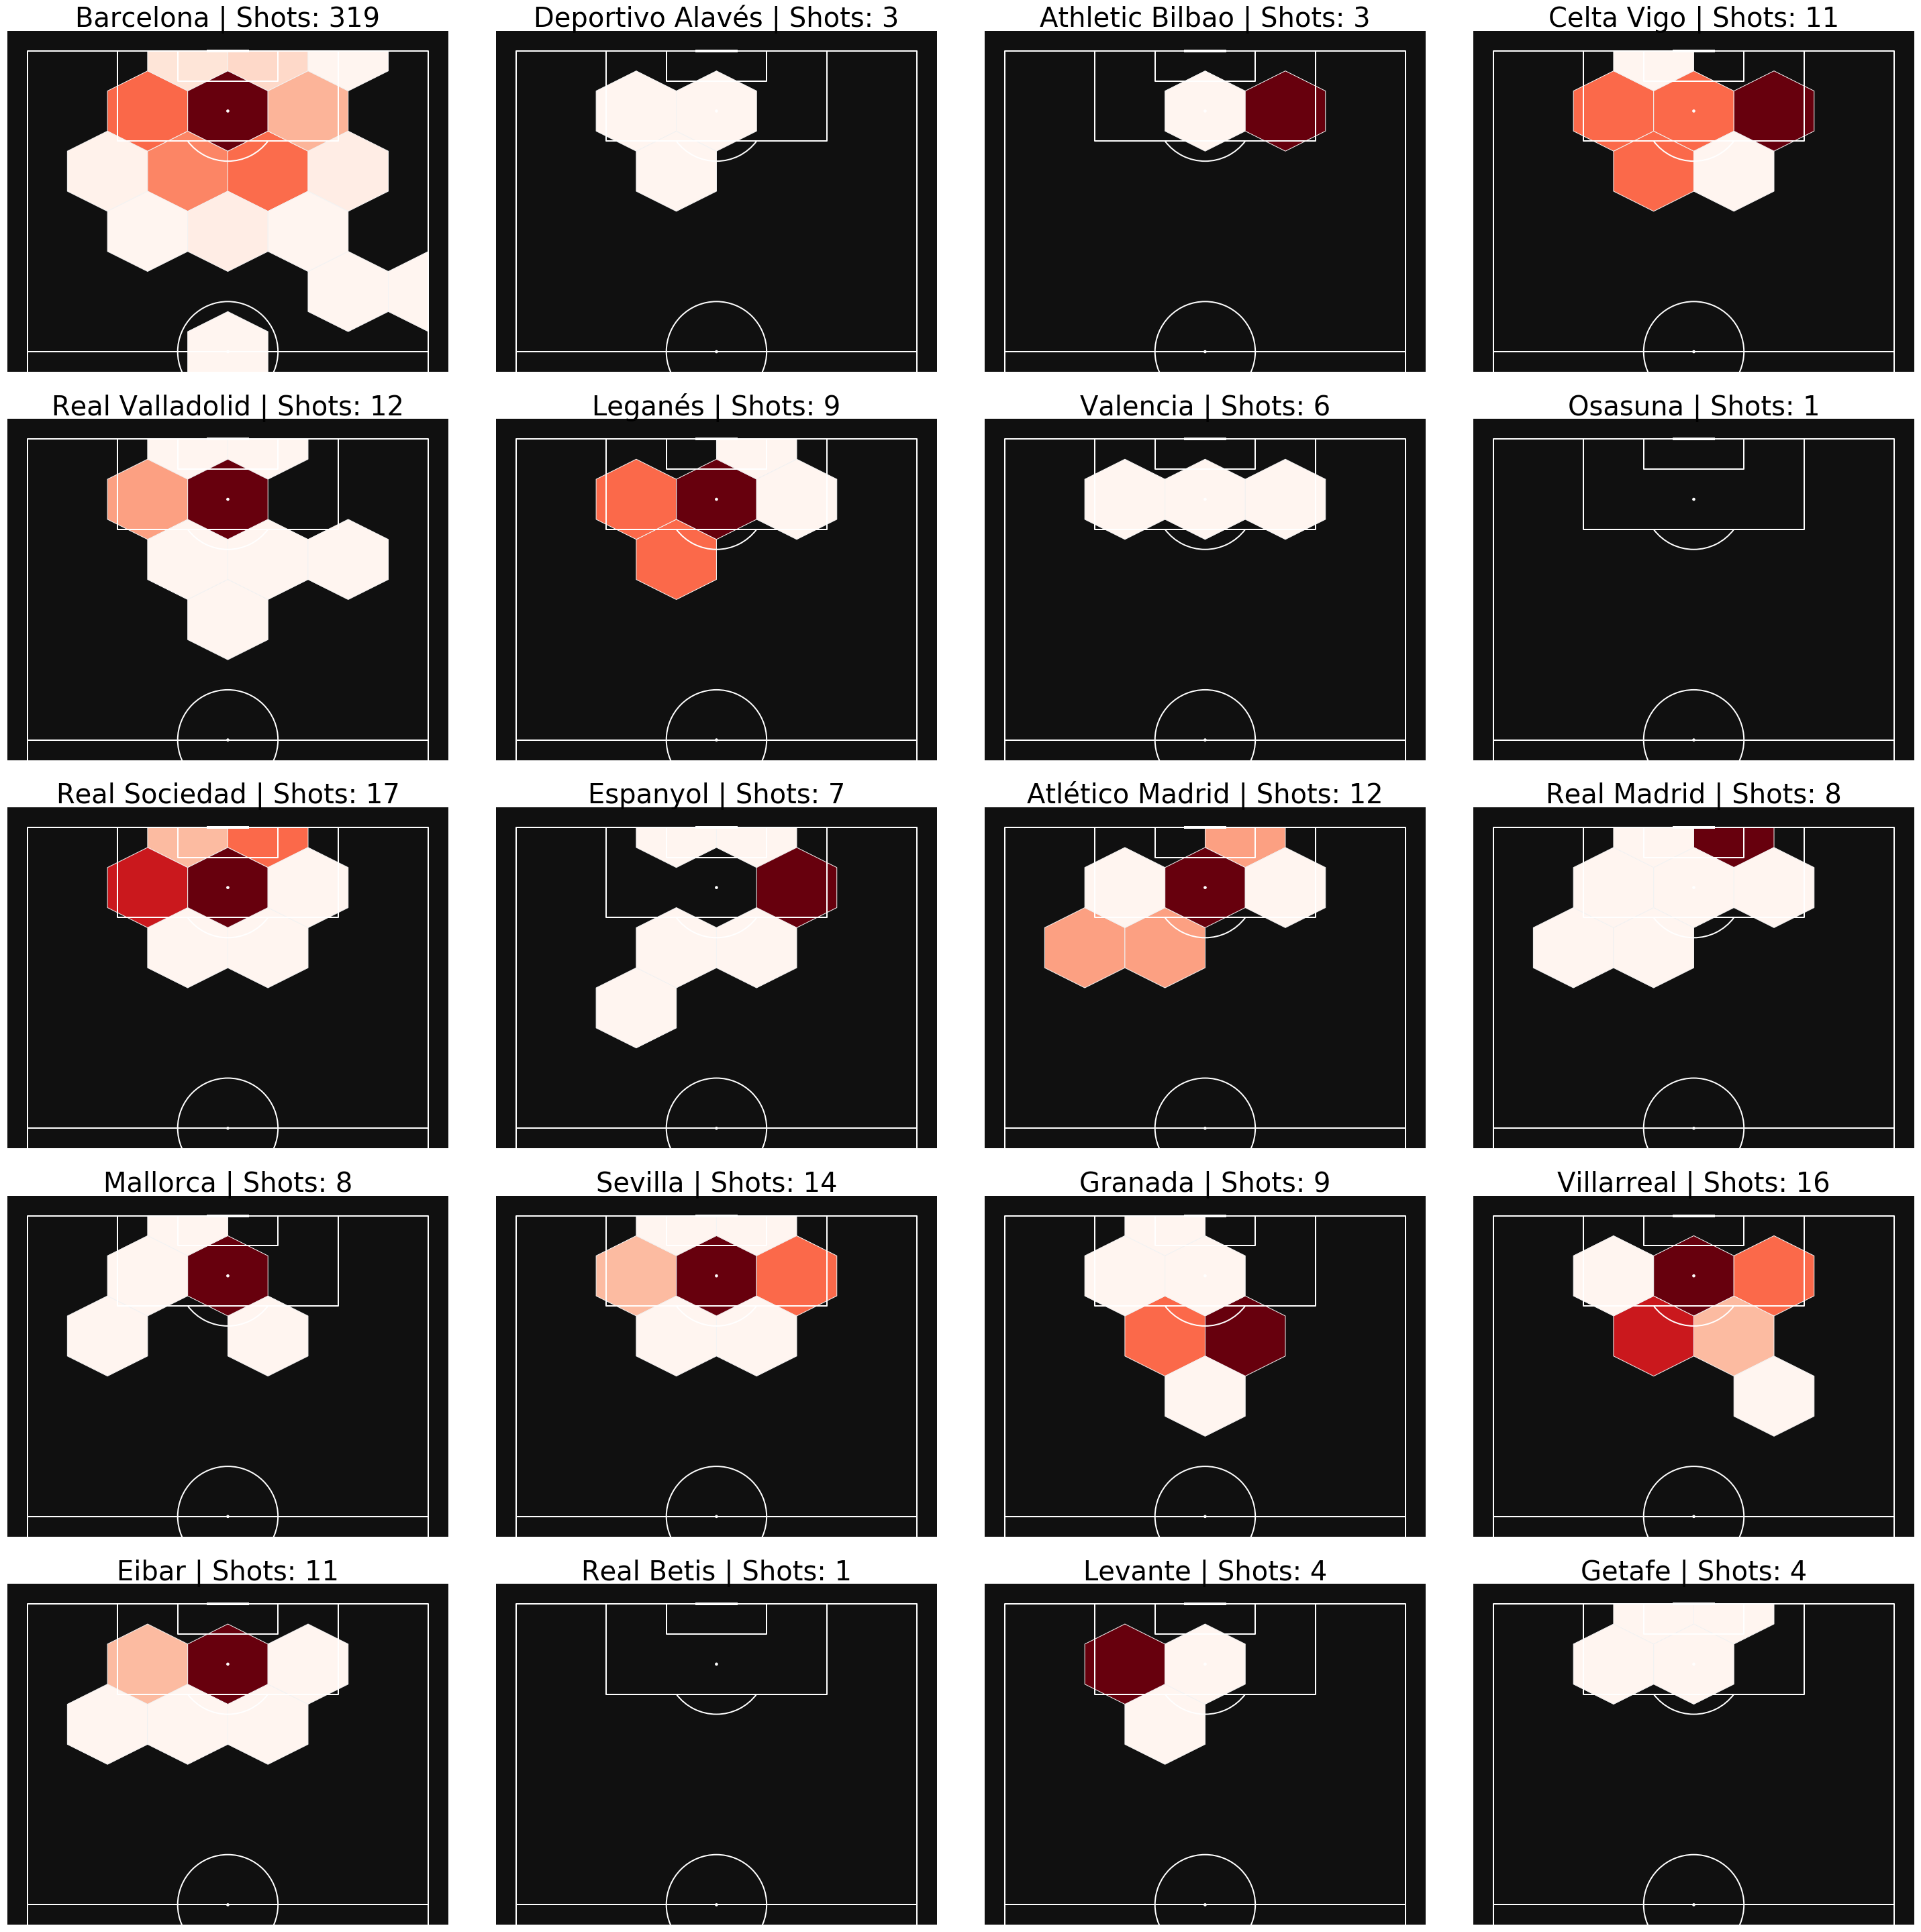

In [760]:
pitch = mplsoccer.VerticalPitch(line_color='white', line_zorder=2, pitch_color='#101010', half=True)
fig, axs = pitch.grid(nrows=5, ncols=4, space=0.1, figheight=40,
                      title_height=0, endnote_height=0,  # no title/ endnote
                      grid_width=0.9, grid_height=0.98, bottom=0.01, left=0.05)
teamIDs = shotData["possession_team.id"].unique()
for idx, ax in enumerate(axs['pitch'].flat):
    teamShotsData = shotData[shotData["possession_team.id"] == teamIDs[idx]]
    hexmap = pitch.hexbin(teamShotsData["startX"], teamShotsData["startY"], ax=ax, edgecolors='#f4f4f4',
                          gridsize=(5, 5), cmap="Reds")
    ax.set_title(teamShotsData["possession_team.name"].unique().item() + " | Shots: " + str(len(teamShotsData)),
                 fontsize=40)

### Player-Wise (Barcelona)

In [761]:
barcaEventData = shotData[shotData["team.id"] == 217]

In [763]:
barcaEventData["player.name"].unique()

10

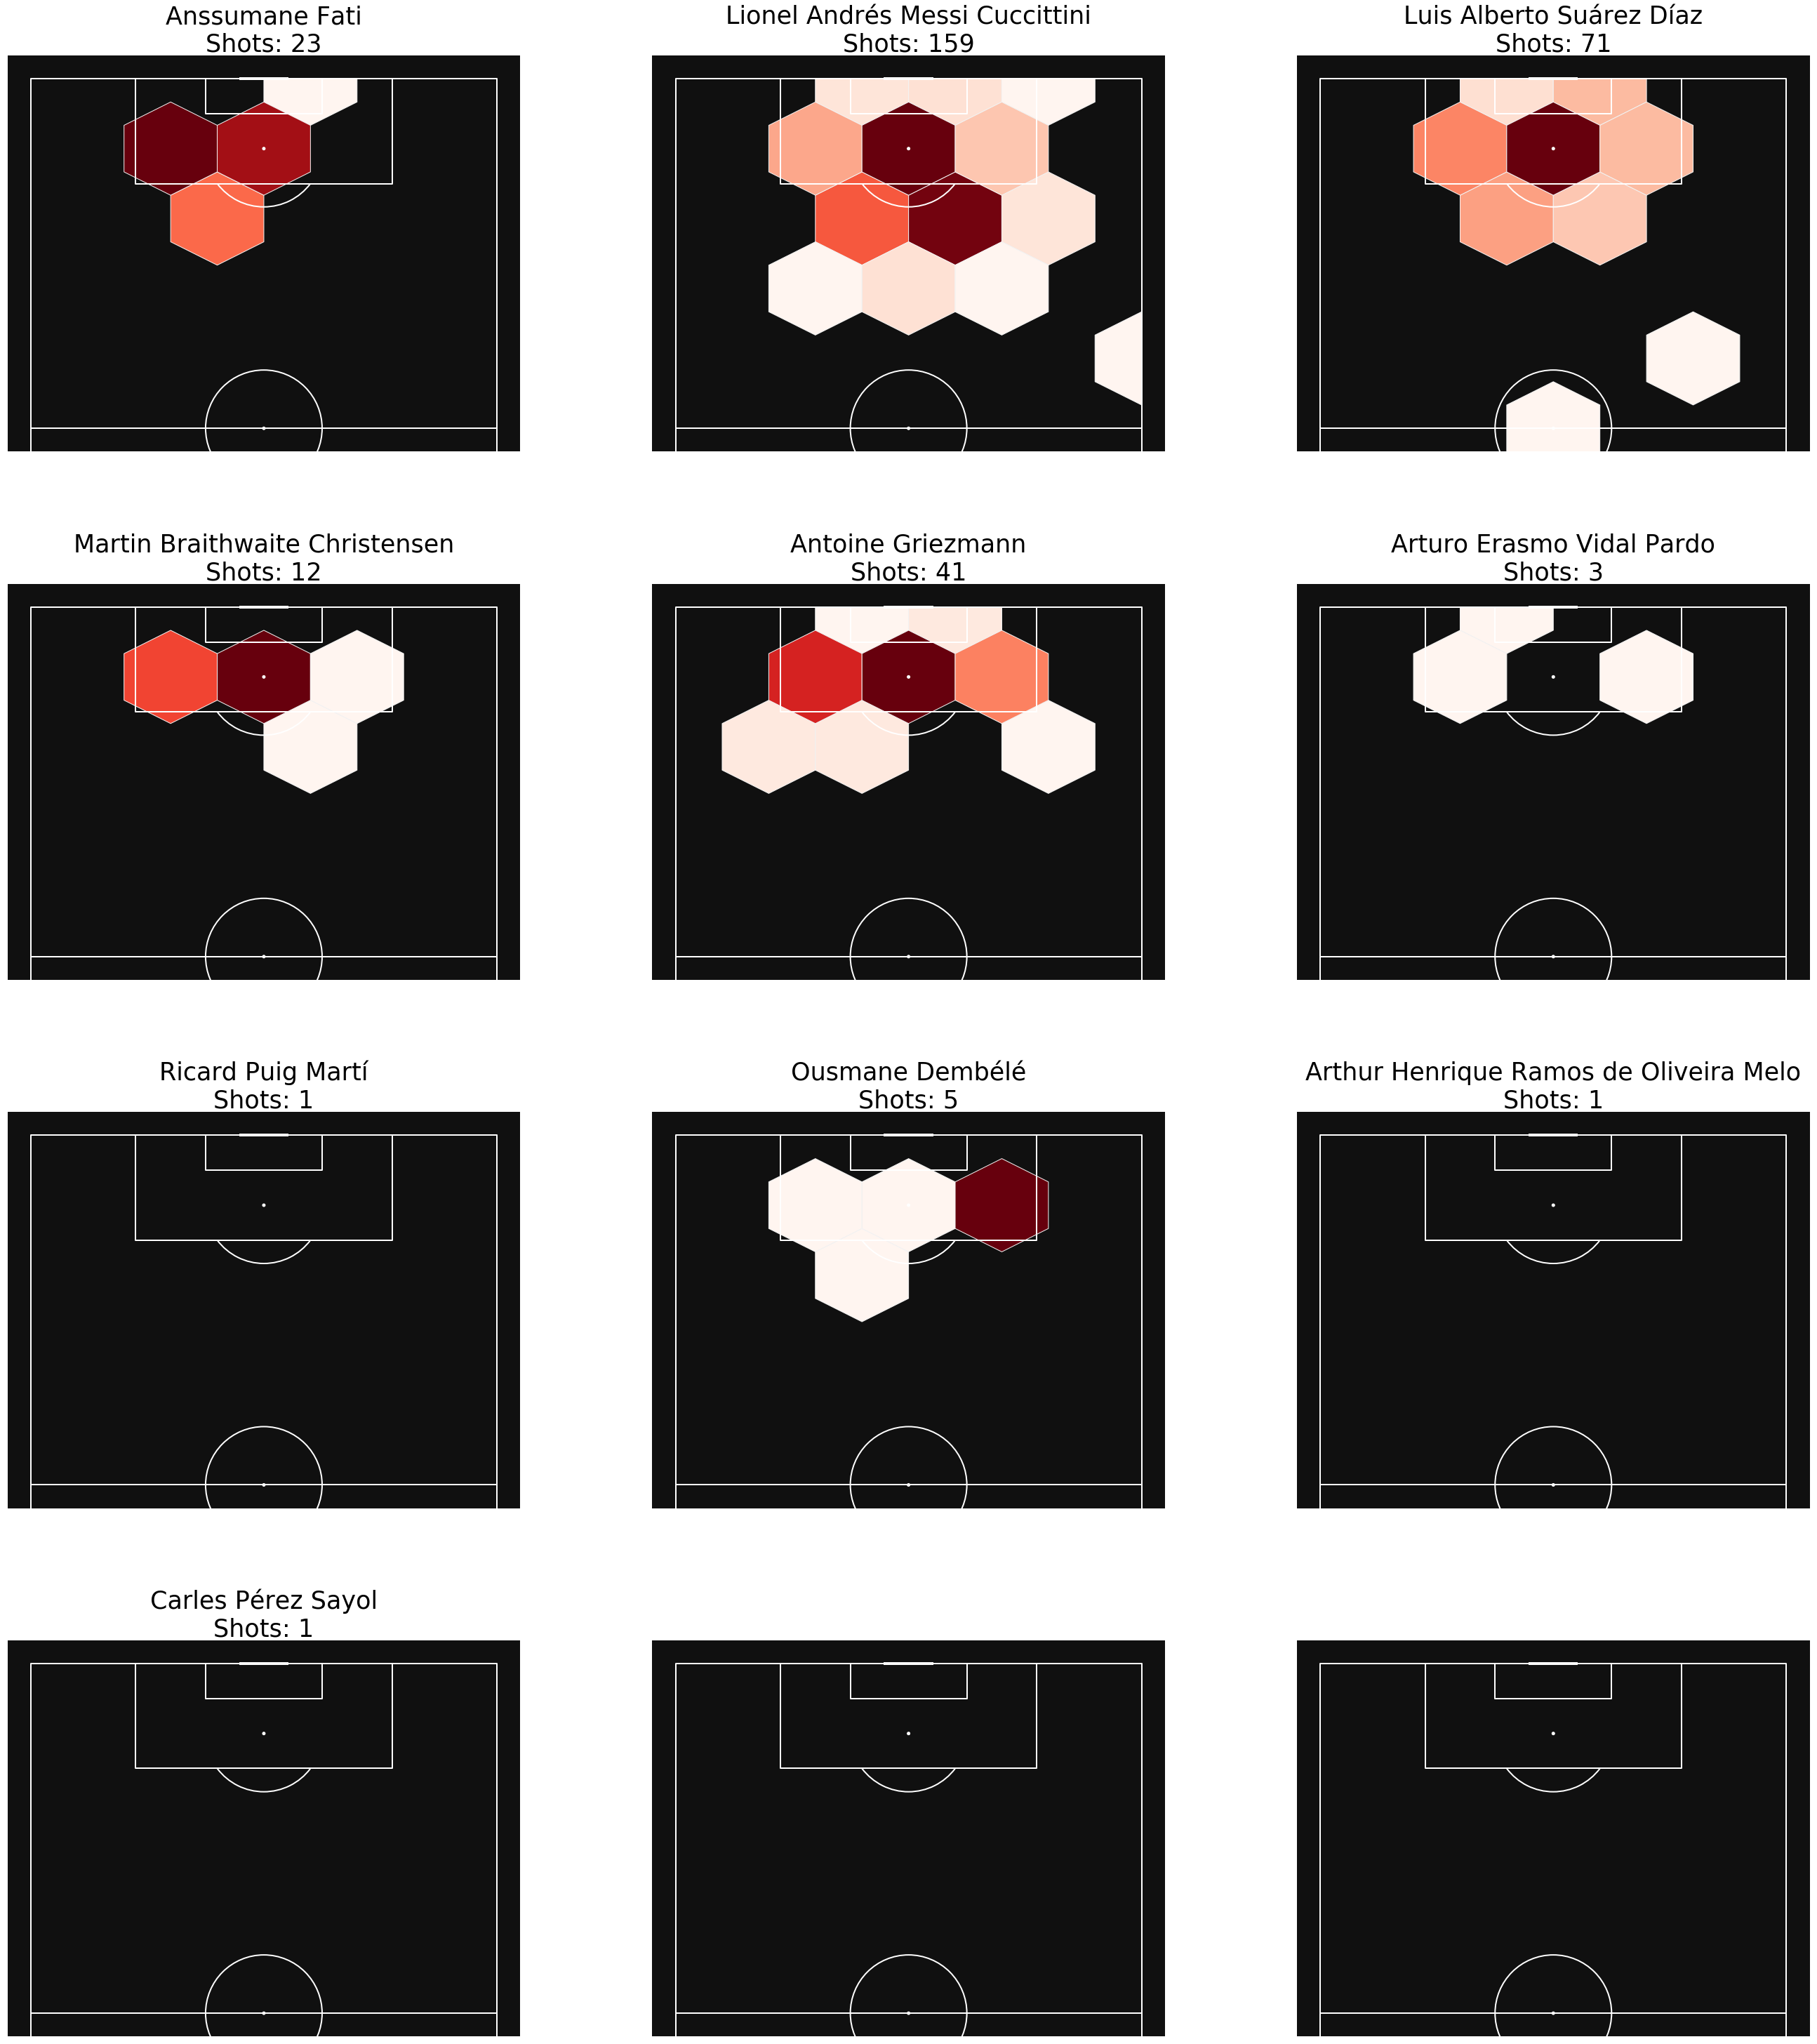

In [765]:
pitch = mplsoccer.VerticalPitch(line_color='white', line_zorder=2, pitch_color='#101010', half=True)
fig, axs = pitch.grid(nrows=4, ncols=3, space=0.2, figheight=40,
                      title_height=0, endnote_height=0,  # no title/ endnote
                      grid_width=0.9, grid_height=0.98, bottom=0.01, left=0.05)
playerIDs = barcaEventData["player.id"].unique()
for idx, ax in enumerate(axs['pitch'].flat):
    if idx < len(playerIDs):
        playerShotsData = barcaEventData[barcaEventData["player.id"] == playerIDs[idx]]
        hexmap = pitch.hexbin(playerShotsData["startX"], playerShotsData["startY"], ax=ax, edgecolors='#f4f4f4',
                              gridsize=(5, 5), cmap="Reds")
        ax.set_title(playerShotsData["player.name"].unique().item() + "\nShots: " + str(len(playerShotsData)),
                     fontsize=35)


# Shot Analysis

## Barcelona

In [769]:
barcaAttData = shotData[shotData["team.id"] == 217]

In [770]:
shotCols

['match_id',
 'id',
 'timestamp',
 'minute',
 'second',
 'type.id',
 'type.name',
 'possession_team.id',
 'possession_team.name',
 'play_pattern.id',
 'play_pattern.name',
 'team.id',
 'team.name',
 'player.id',
 'jersey_number',
 'player.name',
 'position.id',
 'position.name',
 'under_pressure',
 'location',
 'started',
 'minsPlayed',
 'shot.statsbomb_xg',
 'shot.end_location',
 'shot.key_pass_id',
 'shot.technique.id',
 'shot.technique.name',
 'shot.body_part.id',
 'shot.body_part.name',
 'shot.type.id',
 'shot.type.name',
 'shot.outcome.id',
 'shot.outcome.name',
 'shot.freeze_frame',
 'shot.first_time',
 'shot.one_on_one',
 'shot.redirect',
 'shot.aerial_won',
 'shot.open_goal',
 'shot.saved_to_post',
 'shot.deflected',
 'shot.saved_off_target']

In [771]:
shotData[["shot.outcome.id", "shot.outcome.name"]].drop_duplicates()

shot.outcome.id shot.outcome.name
471               98.0             Off T
759               99.0              Post
779              100.0             Saved
1069              97.0              Goal
1567              96.0           Blocked
3803             101.0           Wayward
33324            115.0  Saved Off Target

In [772]:
barcaAttData.groupby(["player.id"]).agg({"player.name": "first",
                                     "team.name": "first",
                                     "type.id": "count",
                                     "shot.outcome.id": [lambda x: x.isin([97, 100]).sum(),
                                                         lambda x: (x == 97).sum()],
                                     "shot.statsbomb_xg": "sum"})

player.name  team.name type.id  \
                                            first      first   count   
player.id                                                              
4447.0             Martin Braithwaite Christensen  Barcelona      12   
5246.0                   Luis Alberto Suárez Díaz  Barcelona      71   
5477.0                            Ousmane Dembélé  Barcelona       5   
5487.0                          Antoine Griezmann  Barcelona      41   
5503.0             Lionel Andrés Messi Cuccittini  Barcelona     159   
8206.0                  Arturo Erasmo Vidal Pardo  Barcelona       3   
11392.0    Arthur Henrique Ramos de Oliveira Melo  Barcelona       1   
24841.0                         Ricard Puig Martí  Barcelona       1   
25006.0                        Carles Pérez Sayol  Barcelona       1   
30756.0                            Anssumane Fati  Barcelona      23   

          shot.outcome.id            shot.statsbomb_xg  
               <lambda_0> <lambda_1>               sum  
player.id                                               
4447.0                7.0        1.0          2.665911  
5246.0               38.0       13.0         12.680841  
5477.0                2.0        1.0          1.035488  
5487.0               16.0        7.0          6.814204  
5503.0               68.0       25.0         19.486048  
8206.0                2.0        1.0          0.234118  
11392.0               0.0        0.0          0.027199  
24841.0               1.0        0.0          0.059284  
25006.0               1.0        0.0          0.171200  
30756.0               8.0        5.0          2.996818

In [773]:
playerShotsData = barcaAttData.groupby(["player.id"]).agg({"player.name": "first",
                                                       "team.name": "first",
                                                       "type.id": "count",
                                                       "shot.outcome.id": [lambda x: x.isin([97, 100, 116]).sum(),
                                                                           lambda x: (x == 97).sum()],
                                                       "shot.statsbomb_xg": "sum"})

In [774]:
playerShotsData.columns = ["player.name", 'team.name', "totShots", "shotsOT", "Goals", "xG"]

In [ ]:
playerShotsData.rename(columns={"type.id": "totShots", "shot.outcome.id": "shotsOT"},
                       inplace=True)

In [775]:
playerMatchMinsdf =\
    barcaAttData.drop_duplicates(subset=["player.id", "match_id"]).groupby(["player.id"])\
        .agg({"minsPlayed": "sum"})

In [776]:
playerMatchMinsdf.shape

(10, 1)

In [777]:
playerShotsData.shape

(10, 6)

In [778]:
pd.concat([playerShotsData, playerMatchMinsdf], axis=1)

player.name  team.name  totShots  \
player.id                                                                
4447.0             Martin Braithwaite Christensen  Barcelona        12   
5246.0                   Luis Alberto Suárez Díaz  Barcelona        71   
5477.0                            Ousmane Dembélé  Barcelona         5   
5487.0                          Antoine Griezmann  Barcelona        41   
5503.0             Lionel Andrés Messi Cuccittini  Barcelona       159   
8206.0                  Arturo Erasmo Vidal Pardo  Barcelona         3   
11392.0    Arthur Henrique Ramos de Oliveira Melo  Barcelona         1   
24841.0                         Ricard Puig Martí  Barcelona         1   
25006.0                        Carles Pérez Sayol  Barcelona         1   
30756.0                            Anssumane Fati  Barcelona        23   

           shotsOT  Goals         xG  minsPlayed  
player.id                                         
4447.0         7.0    1.0   2.665911       300.0  
5246.0        38.0   13.0  12.680841      1816.0  
5477.0         2.0    1.0   1.035488       234.0  
5487.0        16.0    7.0   6.814204      1862.0  
5503.0        68.0   25.0  19.486048      3004.0  
8206.0         2.0    1.0   0.234118       185.0  
11392.0        0.0    0.0   0.027199        38.0  
24841.0        1.0    0.0   0.059284        94.0  
25006.0        1.0    0.0   0.171200         9.0  
30756.0        8.0    5.0   2.996818       626.0

In [779]:
playerShotsData = pd.concat([playerShotsData, playerMatchMinsdf], axis=1)

In [780]:
playerShotsData

player.name  team.name  totShots  \
player.id                                                                
4447.0             Martin Braithwaite Christensen  Barcelona        12   
5246.0                   Luis Alberto Suárez Díaz  Barcelona        71   
5477.0                            Ousmane Dembélé  Barcelona         5   
5487.0                          Antoine Griezmann  Barcelona        41   
5503.0             Lionel Andrés Messi Cuccittini  Barcelona       159   
8206.0                  Arturo Erasmo Vidal Pardo  Barcelona         3   
11392.0    Arthur Henrique Ramos de Oliveira Melo  Barcelona         1   
24841.0                         Ricard Puig Martí  Barcelona         1   
25006.0                        Carles Pérez Sayol  Barcelona         1   
30756.0                            Anssumane Fati  Barcelona        23   

           shotsOT  Goals         xG  minsPlayed  
player.id                                         
4447.0         7.0    1.0   2.665911       300.0  
5246.0        38.0   13.0  12.680841      1816.0  
5477.0         2.0    1.0   1.035488       234.0  
5487.0        16.0    7.0   6.814204      1862.0  
5503.0        68.0   25.0  19.486048      3004.0  
8206.0         2.0    1.0   0.234118       185.0  
11392.0        0.0    0.0   0.027199        38.0  
24841.0        1.0    0.0   0.059284        94.0  
25006.0        1.0    0.0   0.171200         9.0  
30756.0        8.0    5.0   2.996818       626.0

In [781]:
playerShotsData["shotsPer90"] = playerShotsData["totShots"].divide(playerShotsData["minsPlayed"])*90

In [782]:
playerShotsData["shotAccuracy"] = playerShotsData["shotsOT"].divide(playerShotsData["totShots"]).multiply(100).round(1)

In [783]:
playerShotsData

player.name  team.name  totShots  \
player.id                                                                
4447.0             Martin Braithwaite Christensen  Barcelona        12   
5246.0                   Luis Alberto Suárez Díaz  Barcelona        71   
5477.0                            Ousmane Dembélé  Barcelona         5   
5487.0                          Antoine Griezmann  Barcelona        41   
5503.0             Lionel Andrés Messi Cuccittini  Barcelona       159   
8206.0                  Arturo Erasmo Vidal Pardo  Barcelona         3   
11392.0    Arthur Henrique Ramos de Oliveira Melo  Barcelona         1   
24841.0                         Ricard Puig Martí  Barcelona         1   
25006.0                        Carles Pérez Sayol  Barcelona         1   
30756.0                            Anssumane Fati  Barcelona        23   

           shotsOT  Goals         xG  minsPlayed  shotsPer90  shotAccuracy  
player.id                                                                   
4447.0         7.0    1.0   2.665911       300.0    3.600000          58.3  
5246.0        38.0   13.0  12.680841      1816.0    3.518722          53.5  
5477.0         2.0    1.0   1.035488       234.0    1.923077          40.0  
5487.0        16.0    7.0   6.814204      1862.0    1.981740          39.0  
5503.0        68.0   25.0  19.486048      3004.0    4.763648          42.8  
8206.0         2.0    1.0   0.234118       185.0    1.459459          66.7  
11392.0        0.0    0.0   0.027199        38.0    2.368421           0.0  
24841.0        1.0    0.0   0.059284        94.0    0.957447         100.0  
25006.0        1.0    0.0   0.171200         9.0   10.000000         100.0  
30756.0        8.0    5.0   2.996818       626.0    3.306709          34.8

In [784]:
playerShotsDataFiltered = playerShotsData[playerShotsData["totShots"] >= 5]

In [785]:
playerShotsDataFiltered

player.name  team.name  totShots  shotsOT  \
player.id                                                                 
4447.0     Martin Braithwaite Christensen  Barcelona        12      7.0   
5246.0           Luis Alberto Suárez Díaz  Barcelona        71     38.0   
5477.0                    Ousmane Dembélé  Barcelona         5      2.0   
5487.0                  Antoine Griezmann  Barcelona        41     16.0   
5503.0     Lionel Andrés Messi Cuccittini  Barcelona       159     68.0   
30756.0                    Anssumane Fati  Barcelona        23      8.0   

           Goals         xG  minsPlayed  shotsPer90  shotAccuracy  
player.id                                                          
4447.0       1.0   2.665911       300.0    3.600000          58.3  
5246.0      13.0  12.680841      1816.0    3.518722          53.5  
5477.0       1.0   1.035488       234.0    1.923077          40.0  
5487.0       7.0   6.814204      1862.0    1.981740          39.0  
5503.0      25.0  19.486048      3004.0    4.763648          42.8  
30756.0      5.0   2.996818       626.0    3.306709          34.8

In [787]:
playerShotsDataFiltered.style.bar().set_precision(1)

## Analysing Shot Maps

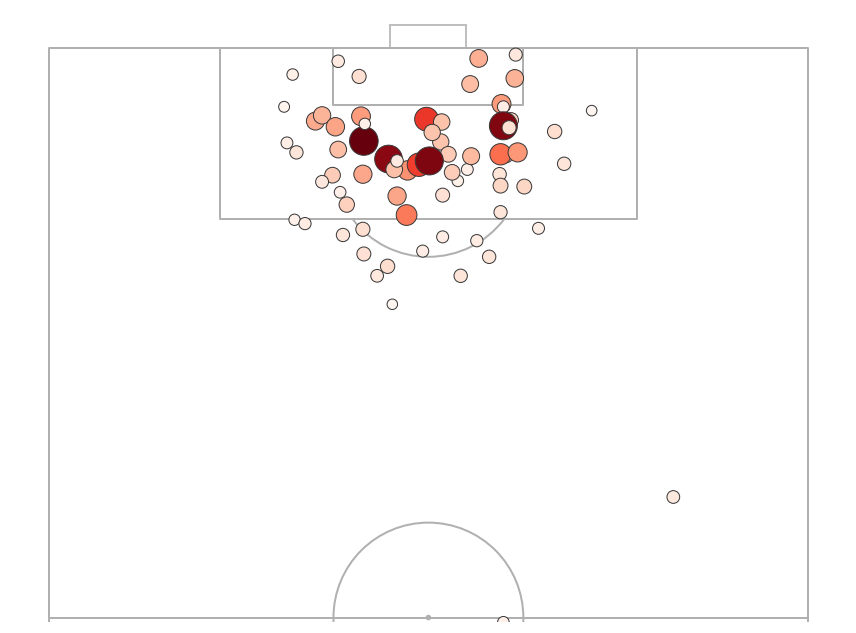

In [788]:
playerID = 5246
playerData = barcaAttData[barcaAttData["player.id"] == playerID]
pitch = mplsoccer.VerticalPitch(pad_bottom=0.5,  # pitch extends slightly below halfway line
                      half=True,  # half of a pitch
                      goal_type='box',
                      goal_alpha=0.8)  # control the goal transparency
fig, ax = pitch.draw(figsize=(12, 10))
sc = pitch.scatter(playerData["startX"], playerData["startY"],
                   s=(playerData["shot.statsbomb_xg"] * 900) + 100,
                   c=playerData["shot.statsbomb_xg"].values.flatten(),
                   edgecolors='#383838',  # give the markers a charcoal border
                   cmap="Reds",
                   marker="o",
                   ax=ax)

In [791]:
pitch = mplsoccer.VerticalPitch(pitch_color="#101010",
                                line_color="white",
                                pad_bottom=1,  # pitch extends slightly below halfway line
                                half=True,  # half of a pitch
                                goal_type='box',
                                goal_alpha=0.8)  # control the goal transparency
fig, axs = pitch.grid(nrows=3, ncols=2, space=0.1, figheight=40,
                      title_height=0, endnote_height=0,  # no title/ endnote
                      grid_width=0.9, grid_height=0.98, bottom=0.01, left=0.05)
playerIDs = playerShotsDataFiltered.index
for idx, ax in enumerate(axs['pitch'].flat):
    playerData = barcaAttData[barcaAttData["player.id"] == playerIDs[idx]]
    sc = pitch.scatter(playerData["startX"], playerData["startY"],
                       s=(playerData["shot.statsbomb_xg"] * 5000) + 100,
                       c=playerData["shot.statsbomb_xg"].values.flatten(),
                       edgecolors='#383838',  # give the markers a charcoal border
                       marker="o",
                       cmap="Reds",
                       ax=ax)
    ax.set_title(playerData["player.name"].unique().item() + "\nShots: " + str(len(playerData))
                 + " | Goals: " + str(playerShotsData.loc[playerIDs[idx], "Goals"].sum().item()),
                 fontsize=35)


In [792]:
pitch = mplsoccer.VerticalPitch(pitch_color="#101010",
                                line_color="white",
                                pad_bottom=1,  # pitch extends slightly below halfway line
                                half=True,  # half of a pitch
                                goal_type='box',
                                goal_alpha=0.8)  # control the goal transparency

fig, axs = pitch.grid(nrows=3, ncols=2, space=0.1, figheight=40,
                      title_height=0, endnote_height=0,  # no title/ endnote
                      grid_width=0.9, grid_height=0.98, bottom=0.01, left=0.05)

playerIDs = playerShotsData.index
for idx, ax in enumerate(axs['pitch'].flat):
    playerData = barcaAttData[barcaAttData["player.id"] == playerIDs[idx]]
    ngplayerData = playerData[playerData["shot.outcome.id"] != 97]
    gplayerData = playerData[playerData["shot.outcome.id"] == 97]
    
    sc = pitch.scatter(ngplayerData["startX"], ngplayerData["startY"],
                       s=(ngplayerData["shot.statsbomb_xg"] * 5000) + 100,
                       c="None",
                       edgecolors='#ffffff',  # give the markers a white border
                       marker="o",
                       ax=ax)
    sc2 = pitch.scatter(gplayerData["startX"], gplayerData["startY"],
                       s=(gplayerData["shot.statsbomb_xg"] * 5000) + 100,
                       c="white",
                       edgecolors='#383838',  # give the markers a charcoal border
                       marker="football",
                       ax=ax)

    totGoals = playerShotsData.loc[playerIDs[idx], "Goals"].sum().item()
    totxG = playerShotsData.loc[playerIDs[idx], "xG"].sum().round(1).item()
    ax.set_title(playerData["player.name"].unique().item() + "\nShots: " + str(len(playerData))
                 + " | Goals: " + str(totGoals) + " | xG: " + str(totxG),
                 fontsize=35)


## Surpassing Expectations

In [793]:
fig = px.scatter(x="xG", y="Goals",
                 data_frame=playerShotsData,
                 text="player.name", size="xG",
                 opacity=.8)
fig.add_trace(go.Scatter(x=[0, playerShotsData[["Goals", "xG"]].max().max()],
                         y=[0, playerShotsData[["Goals", "xG"]].max().max()]))

fig.update_traces(textposition='top center', textfont_size=10)
fig.update_layout(showlegend=True, height=600, width=1000)
fig.show()

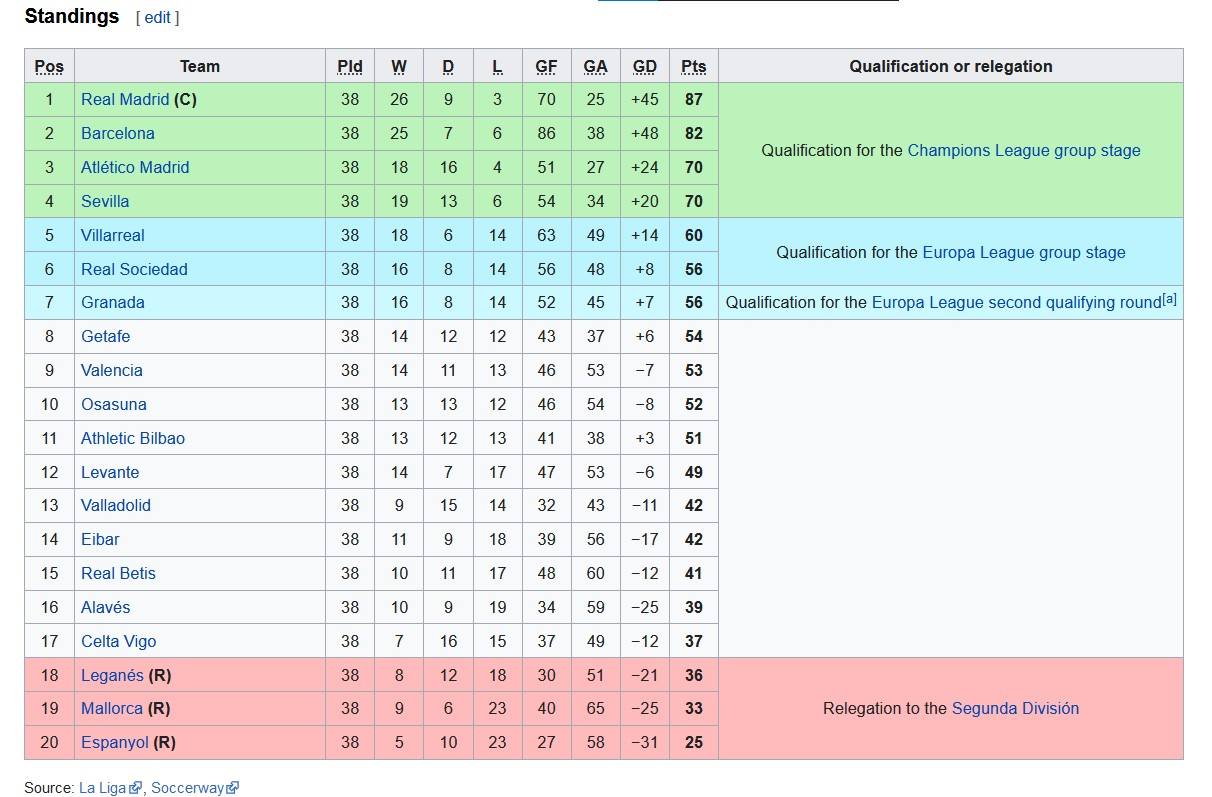

In [794]:
from IPython.display import Image
Image("../pics/standingsLL19_20.jpg")

# Carry Analysis

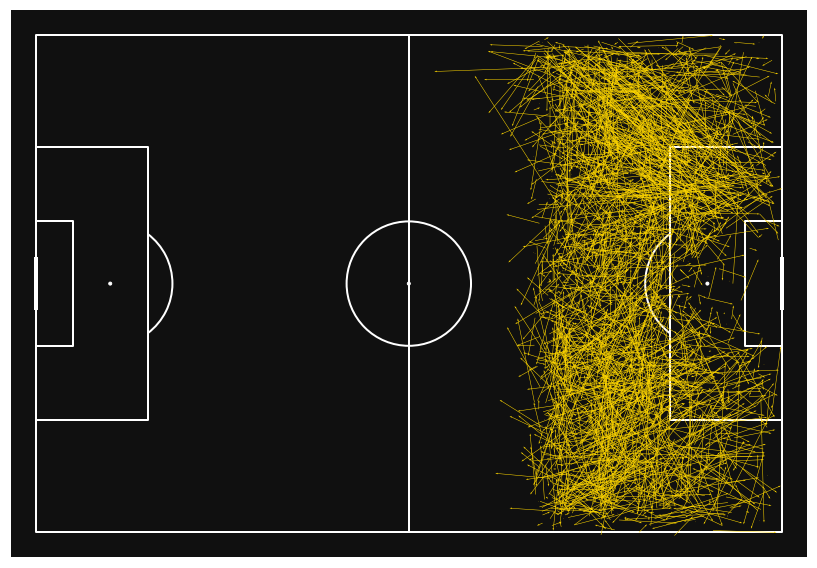

In [797]:
pitch = mplsoccer.Pitch(pitch_color='#101010', line_color='white')
fig, ax = pitch.draw(figsize=(16, 8))

arrows = pitch.arrows(carryData["startX"], carryData["startY"],
                      carryData["endXCarry"], carryData["endYCarry"],
                      ax=ax,
                      width=.5,
                      color="gold")

In [798]:
playerShotsData.shape

(10, 9)

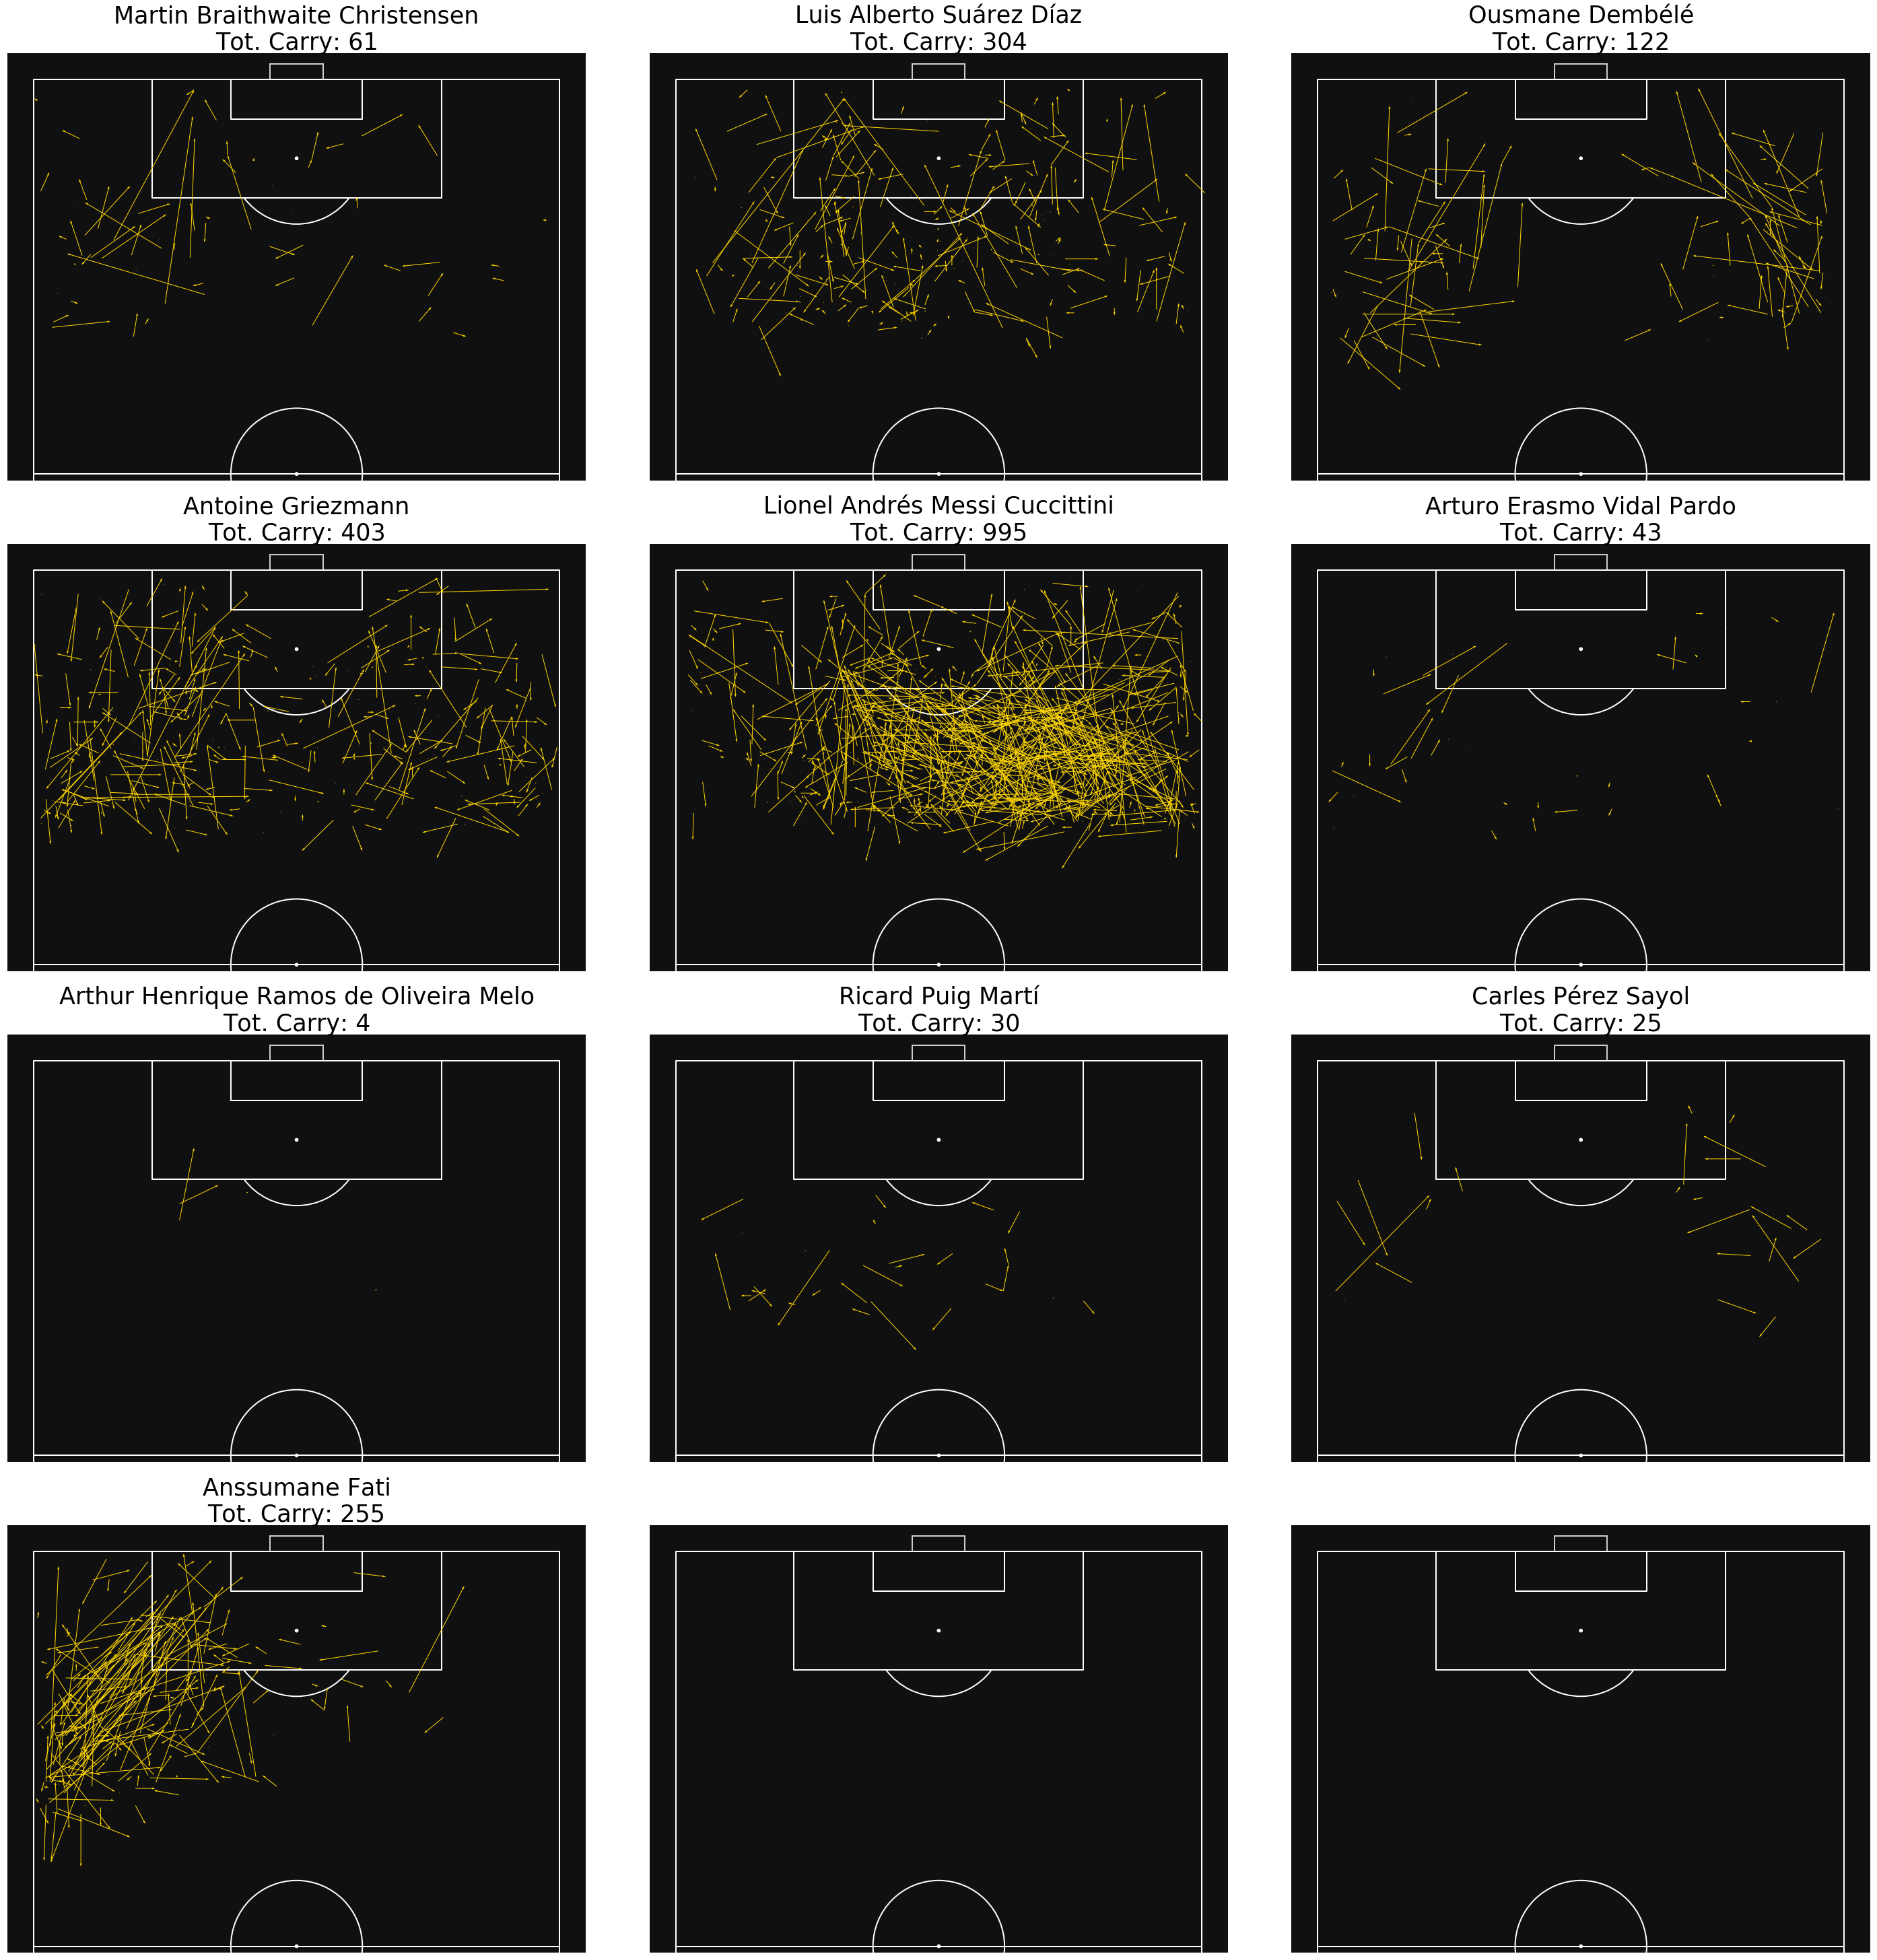

In [799]:
pitch = mplsoccer.VerticalPitch(pitch_color="#101010",
                                line_color="white",
                                pad_bottom=1,  # pitch extends slightly below halfway line
                                half=True,  # half of a pitch
                                goal_type='box',
                                goal_alpha=0.8)  # control the goal transparency
fig, axs = pitch.grid(nrows=4, ncols=3, space=0.1, figheight=40,
                      title_height=0, endnote_height=0,  # no title/ endnote
                      grid_width=0.9, grid_height=0.98, bottom=0.01, left=0.05)
playerIDs = playerShotsData.index
for idx, ax in enumerate(axs['pitch'].flat):
    if idx < len(playerIDs):
        playerData = carryData[carryData["player.id"] == playerIDs[idx]]
        arrows = pitch.arrows(playerData["startX"], playerData["startY"],
                              playerData["endXCarry"], playerData["endYCarry"],
                              ax=ax,
                              width=1,
                              color="gold")
        ax.set_title(playerData["player.name"].unique().item() + "\nTot. Carry: " + str(len(playerData)),
                     fontsize=35)


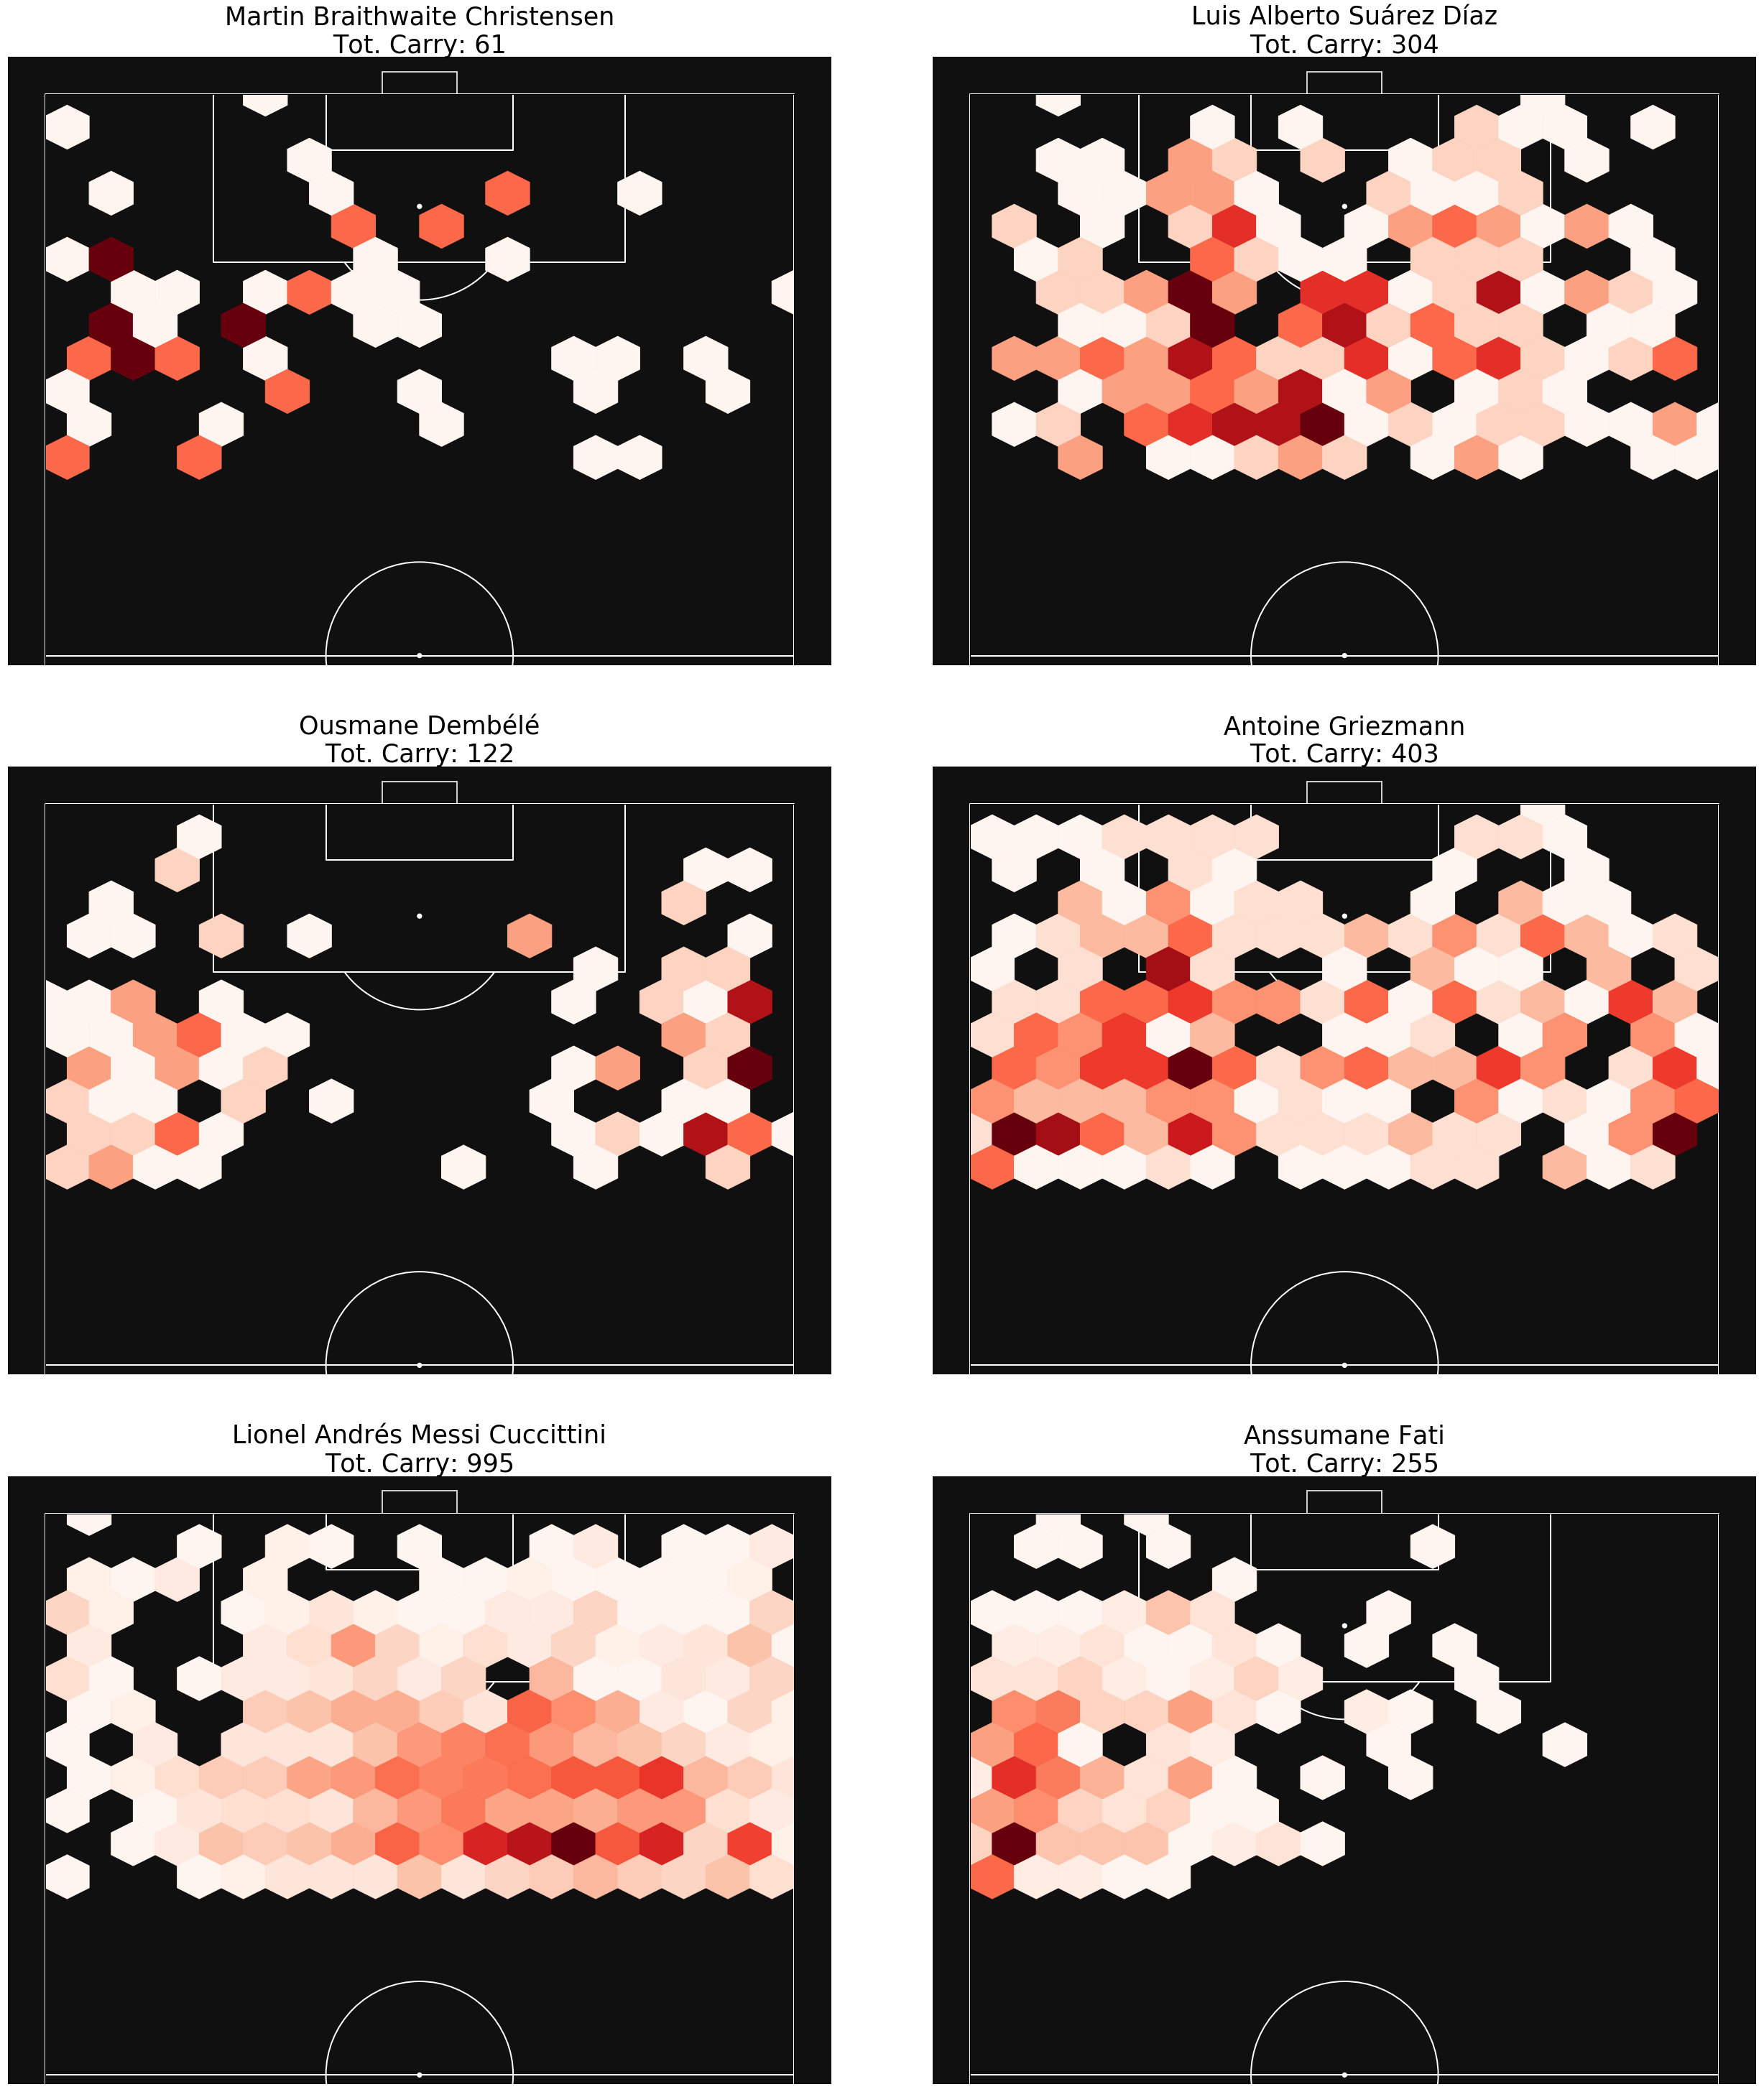

In [800]:
pitch = mplsoccer.VerticalPitch(pitch_color="#101010",
                                line_color="white",
                                pad_bottom=1,  # pitch extends slightly below halfway line
                                half=True,  # half of a pitch
                                goal_type='box',
                                goal_alpha=0.8)  # control the goal transparency
fig, axs = pitch.grid(nrows=3, ncols=2, space=0.1, figheight=40,
                      title_height=0, endnote_height=0,  # no title/ endnote
                      grid_width=0.9, grid_height=0.98, bottom=0.01, left=0.05)
playerIDs = playerShotsDataFiltered.index
for idx, ax in enumerate(axs['pitch'].flat):
    if idx < len(playerIDs):
        playerData = carryData[carryData["player.id"] == playerIDs[idx]]
        arrows = pitch.hexbin(playerData["startX"], playerData["startY"],
                              ax=ax,
                              cmap="Reds")
        ax.set_title(playerData["player.name"].unique().item() + "\nTot. Carry: " + str(len(playerData)),
                     fontsize=35)


In [ ]:
eventDataLL1920.columns[eventDataLL1920.columns.str.contains("carry")]

# Dribble Analysis

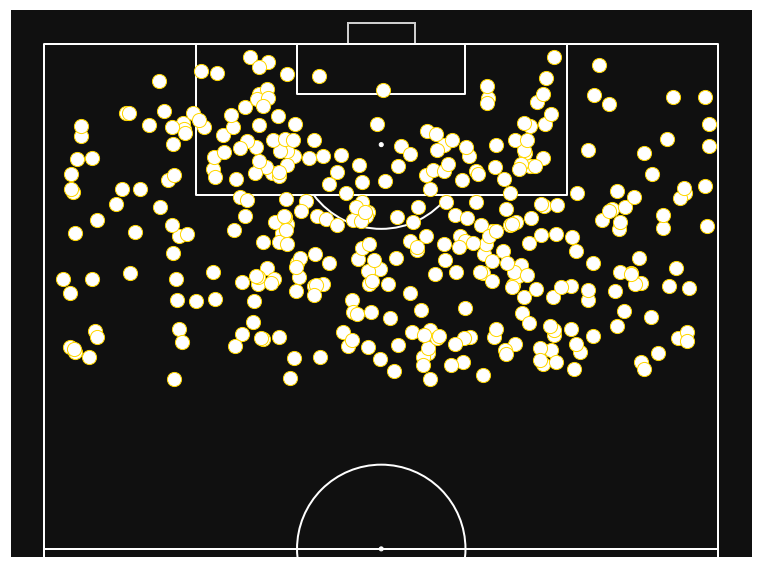

In [805]:
pitch = mplsoccer.VerticalPitch(pitch_color="#101010",
                                line_color="white",
                                pad_bottom=1,  # pitch extends slightly below halfway line
                                half=True,  # half of a pitch
                                goal_type='box',
                                goal_alpha=0.8)  # control the goal transparency

fig, ax = pitch.draw(figsize=(16, 8))

sc = pitch.scatter(dribbleData["startX"], dribbleData["startY"],
                   s=200,
                   c="white",
                   edgecolors='gold',  # give the markers a gold border
                   marker="o",
                   ax=ax)

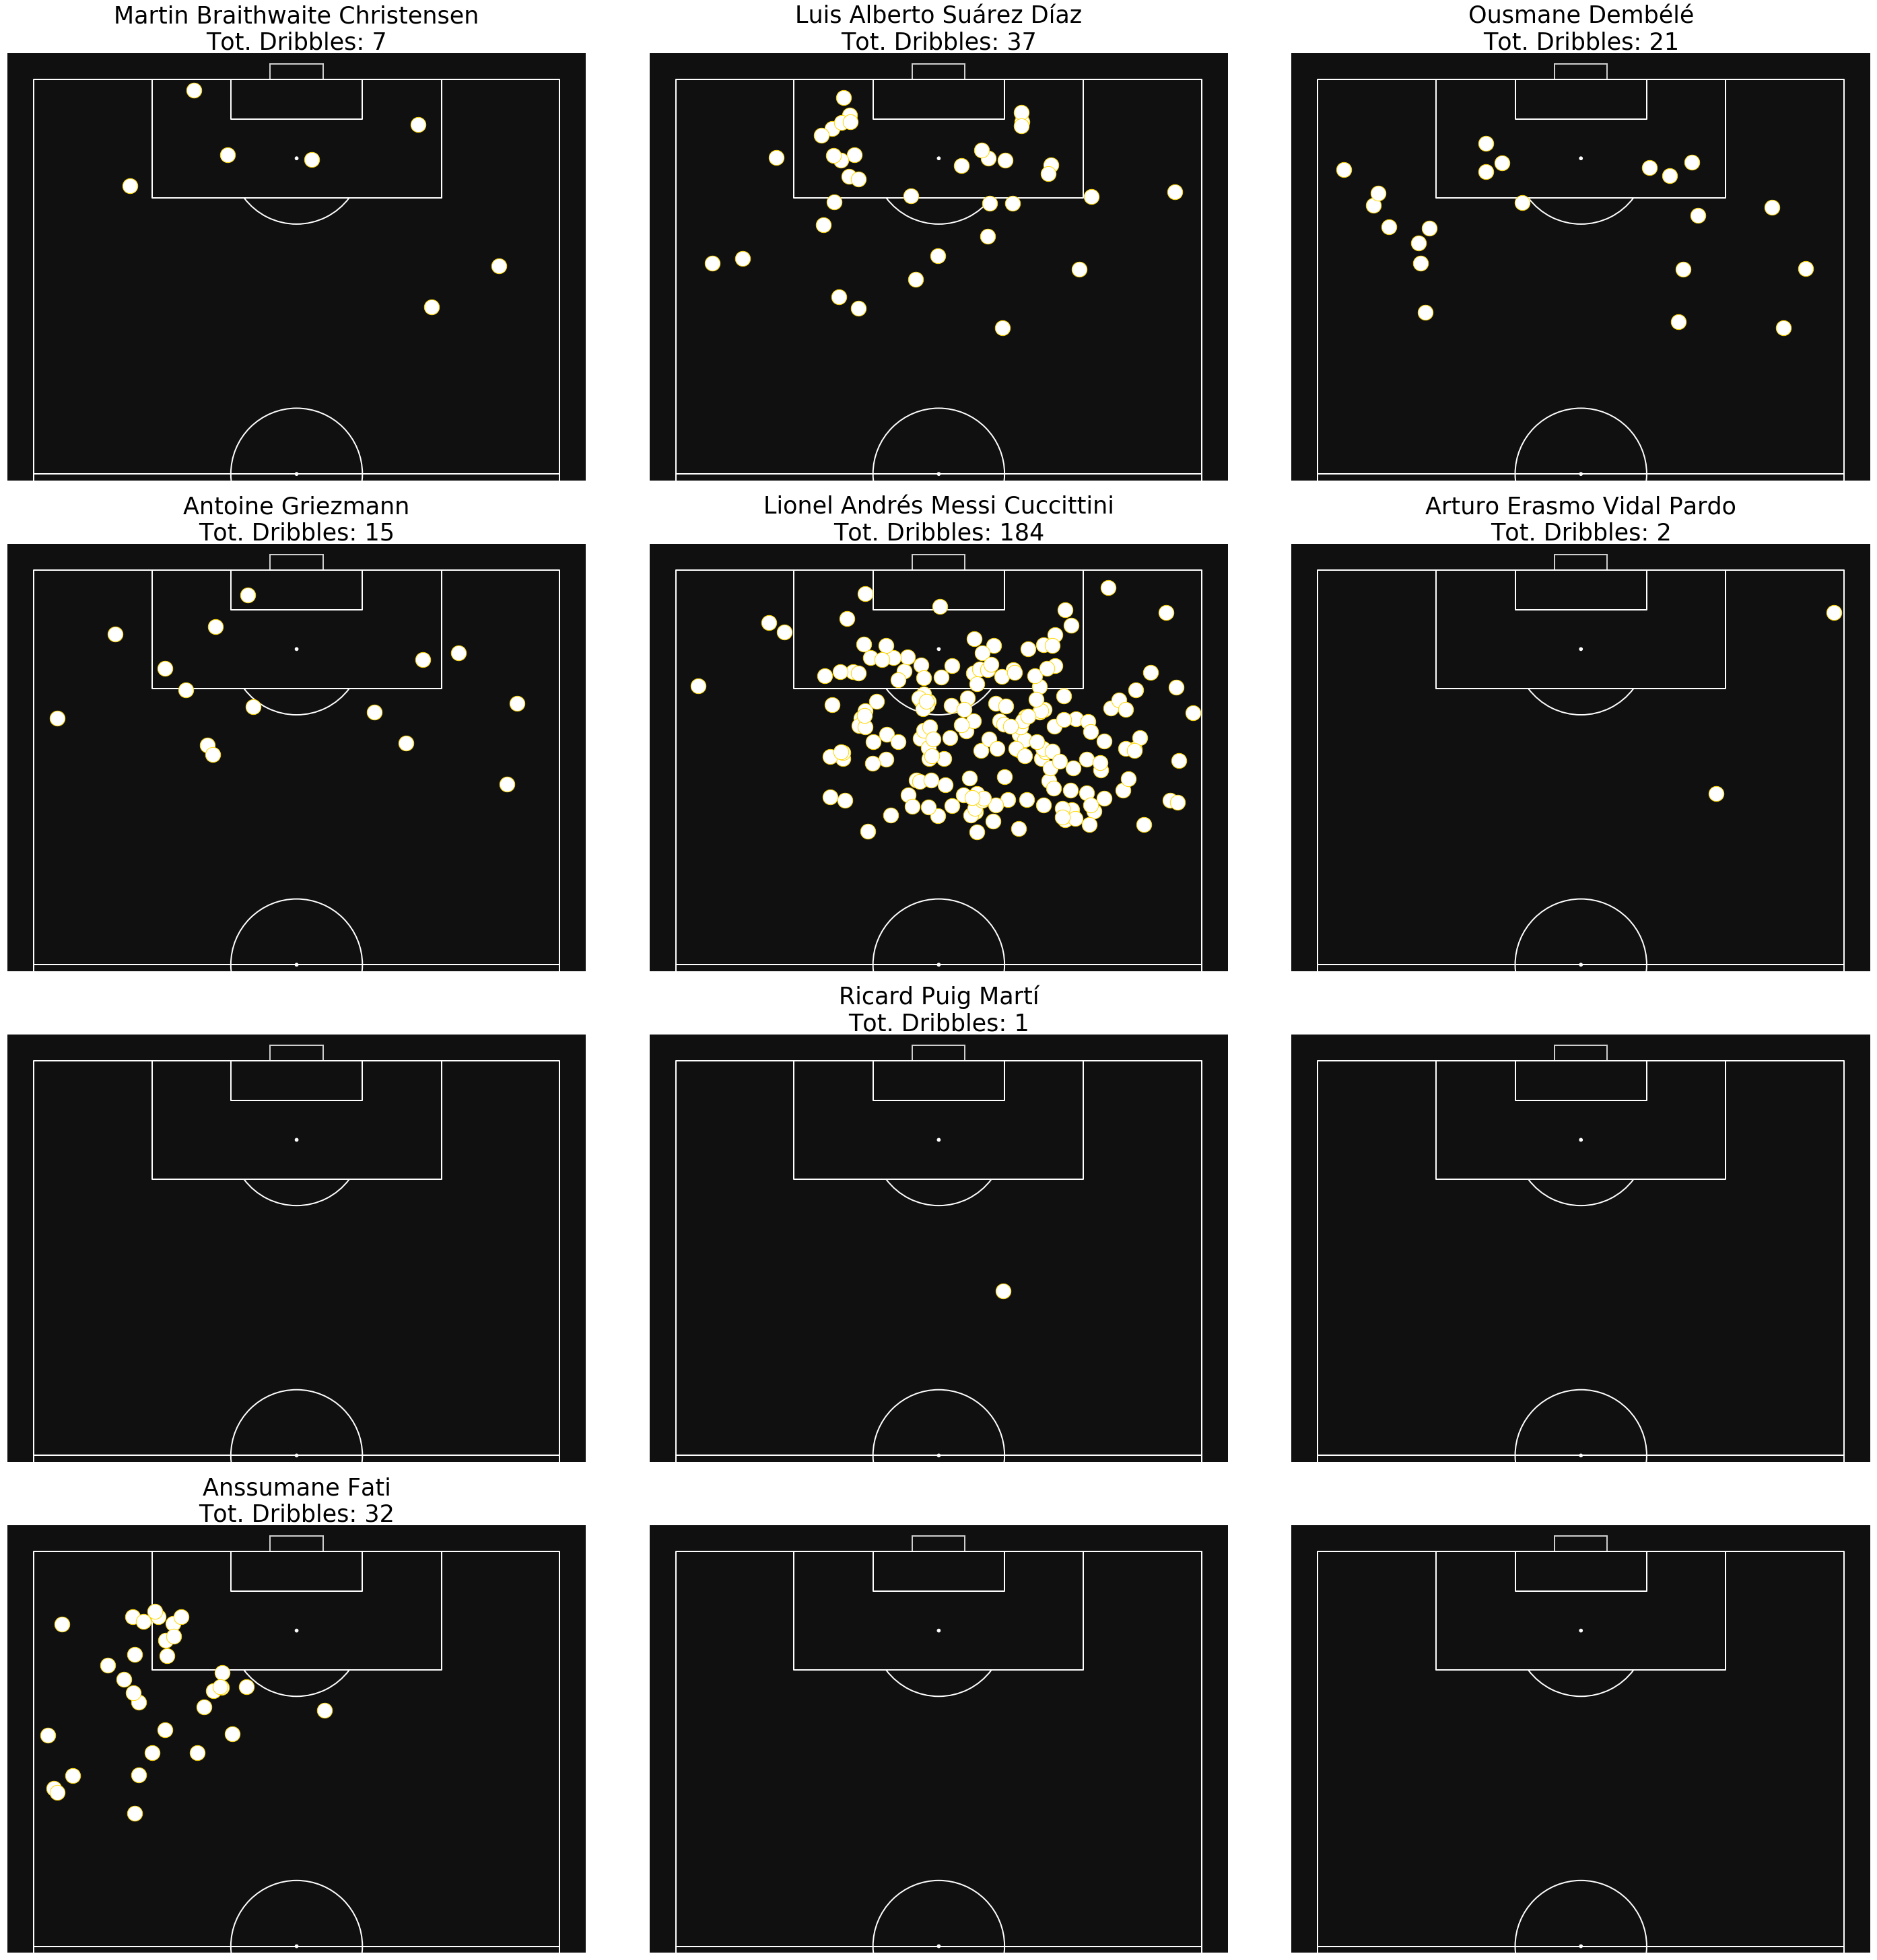

In [810]:
pitch = mplsoccer.VerticalPitch(pitch_color="#101010",
                                line_color="white",
                                pad_bottom=1,  # pitch extends slightly below halfway line
                                half=True,  # half of a pitch
                                goal_type='box',
                                goal_alpha=0.8)  # control the goal transparency
fig, axs = pitch.grid(nrows=4, ncols=3, space=0.1, figheight=40,
                      title_height=0, endnote_height=0,  # no title/ endnote
                      grid_width=0.9, grid_height=0.98, bottom=0.01, left=0.05)
playerIDs = playerShotsData.index
for idx, ax in enumerate(axs['pitch'].flat):
    if idx < len(playerIDs):
        playerData = dribbleData[dribbleData["player.id"] == playerIDs[idx]]
        sc = pitch.scatter(playerData["startX"], playerData["startY"],
                           s=500,
                           c="white",
                           edgecolors='gold',  # give the markers a gold border
                           marker="o",
                           ax=ax)
        try:
            playerName = playerData["player.name"].unique().item()
            ax.set_title(playerName + "\nTot. Dribbles: " + str(len(playerData)),
                         fontsize=35)
        except ValueError:
            pass

In [809]:
playerData["player.name"].unique()

array([], dtype=object)

In [811]:
dribbleData[["dribble.outcome.id","dribble.outcome.name"]].drop_duplicates()

dribble.outcome.id dribble.outcome.name
109                 8.0             Complete
356                 9.0           Incomplete

In [814]:
pitch = mplsoccer.VerticalPitch(pitch_color="#101010",
                                line_color="white",
                                pad_bottom=1,  # pitch extends slightly below halfway line
                                half=True,  # half of a pitch
                                goal_type='box',
                                goal_alpha=0.8)  # control the goal transparency
fig, axs = pitch.grid(nrows=3, ncols=2, space=0.1, figheight=40,
                      title_height=0, endnote_height=0,  # no title/ endnote
                      grid_width=0.9, grid_height=0.98, bottom=0.01, left=0.05)
playerIDs = playerShotsDataFiltered.index
for idx, ax in enumerate(axs['pitch'].flat):
    if idx < len(playerIDs):
        playerData = dribbleData[dribbleData["player.id"] == playerIDs[idx]]
        succplayerData = playerData[playerData["dribble.outcome.id"] == 8]
        unsuccplayerData = playerData[playerData["dribble.outcome.id"] == 9]
        sc = pitch.scatter(succplayerData["startX"], succplayerData["startY"],
                           s=700,
                           c="None",
                           edgecolors='grey',  # give the markers a grey border
                           marker="football",
                           ax=ax)
        sc2 = pitch.scatter(unsuccplayerData["startX"], unsuccplayerData["startY"],
                           s=500,
                           c="red",
                           edgecolors='grey',  # give the markers a grey border
                           marker="o",
                           ax=ax)
        ax.set_title(playerData["player.name"].unique().item(),
                     fontsize=35)


In [817]:
pitch = mplsoccer.VerticalPitch(pitch_color="#101010",
                                line_color="white",
                                pad_bottom=1,  # pitch extends slightly below halfway line
                                half=True,  # half of a pitch
                                goal_type='box',
                                goal_alpha=0.8)  # control the goal transparency
fig, axs = pitch.grid(nrows=3, ncols=2, space=0.1, figheight=40,
                      title_height=0, endnote_height=0,  # no title/ endnote
                      grid_width=0.9, grid_height=0.98, bottom=0.01, left=0.05)
playerIDs = playerShotsDataFiltered.index
for idx, ax in enumerate(axs['pitch'].flat):
    if idx < len(playerIDs):
        playerData = dribbleData[dribbleData["player.id"] == playerIDs[idx]]
        succplayerData = playerData[playerData["dribble.outcome.id"] == 8]
        unsuccplayerData = playerData[playerData["dribble.outcome.id"] == 9]
        sc = pitch.scatter(succplayerData["startX"], succplayerData["startY"],
                           s=700,
                           c="None",
                           edgecolors='grey',  # give the markers a grey border
                           marker="football",
                           ax=ax)
        sc2 = pitch.scatter(unsuccplayerData["startX"], unsuccplayerData["startY"],
                           s=500,
                           c="red",
                           edgecolors='grey',  # give the markers a grey border
                           marker="o",
                           ax=ax)
        totDrib = len(playerData)
        succDrib = len(succplayerData)
        succDribper = round(succDrib/totDrib*100, 1)
        
        ax.set_title(playerData["player.name"].unique().item() + "\nTot. Dribbles: " + str(totDrib)
                     + " | Succ: " + str(succDrib) + " | Succ Per: " + str(succDribper) + "%",
                     fontsize=35)

In [819]:
eventDataLL1920["dribble.nutmeg"].sum()

18

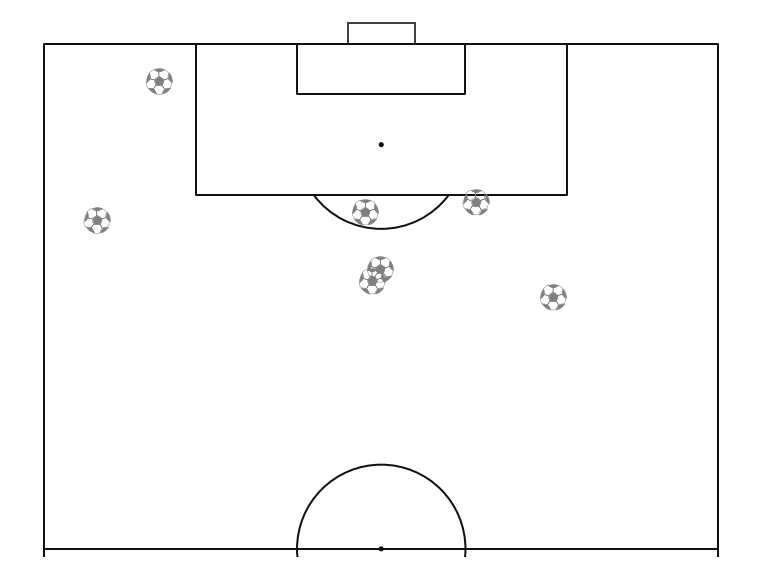

In [822]:
pitch = mplsoccer.VerticalPitch(pitch_color="#ffffff",
                                line_color="#101010",
                                pad_bottom=1,  # pitch extends slightly below halfway line
                                half=True,  # half of a pitch
                                goal_type='box',
                                goal_alpha=0.8)  # control the goal transparency

fig, ax = pitch.draw(figsize=(16, 8))
nutmegData = dribbleData[dribbleData["dribble.nutmeg"] == True]
sc = pitch.scatter(nutmegData["startX"], nutmegData["startY"],
                   s=700,
                   c="None",
                   edgecolors='grey',  # give the markers a grey border
                   marker="football",
                   ax=ax)

# Build-up play contribution

## xGChain Computation

Definitions: **xGChain** and **xGBuildup** \

**xGChain** --> Calculating xG for possessions that lead to a shot where the player was involved at least once in that possession, **INCLUDING** the final pass or the shot. \

**xGBuildup** --> Calculating xG for possessions that lead to a shot where the player was involved at least once in that possession, **EXCLUDING** the final pass or the shot.

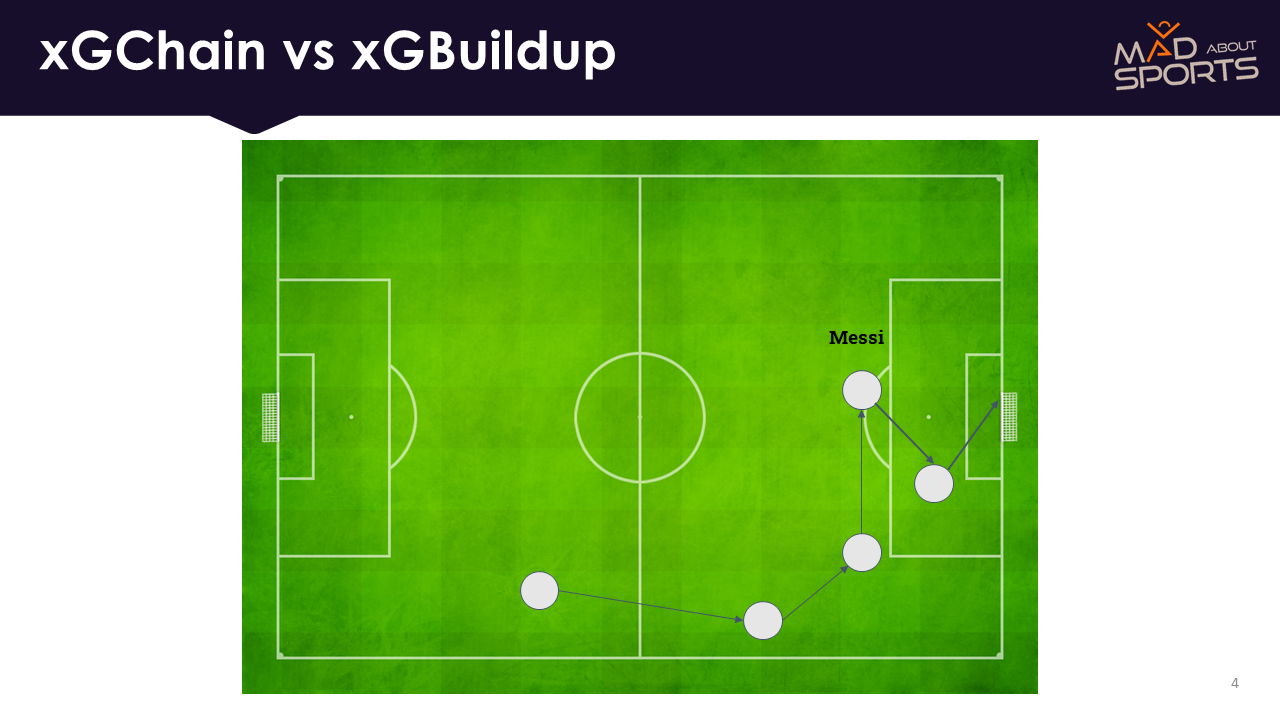

In [824]:
from IPython.display import Image
Image("../pics/xGC_xGB_explained.png")

### Get the Possession Chains

In [825]:
eventDataLL1920.groupby(["match_id", "possession"])["player.name"].apply(list)

match_id  possession
303377    2             [Antoine Griezmann, Jorge Molina Vidal, Antoin...
          3                           [Anssumane Fati, Antoine Griezmann]
          4                      [Jorge Molina Vidal, Jorge Molina Vidal]
          6             [Jaime Mata Arnaiz, Jaime Mata Arnaiz, Jaime M...
          7             [Antoine Griezmann, Antoine Griezmann, Antoine...
                                              ...                        
303731    180           [Enrique González Casín, Lionel Andrés Messi C...
          181           [Enrique González Casín, Pablo Ezequiel De Bla...
          182           [Fabián Ariel Orellana Valenzuela, Martin Brai...
          183           [Enrique González Casín, Martin Braithwaite Ch...
          184           [Pablo Ezequiel De Blasis, Gonzalo Escalante, ...
Name: player.name, Length: 4657, dtype: object

In [826]:
xgChainData = eventDataLL1920.groupby(["match_id", "possession"])["player.name"].apply(list)

In [827]:
eventDataLL1920.groupby(["match_id", "possession"])["shot.statsbomb_xg"].sum()

match_id  possession
303377    2             0.000000
          3             0.000000
          4             0.000000
          6             0.000000
          7             0.000000
                          ...   
303731    180           0.835386
          181           0.000000
          182           0.364813
          183           0.000000
          184           0.000000
Name: shot.statsbomb_xg, Length: 4657, dtype: float64

In [828]:
eventDataLL1920.groupby(["match_id", "possession"]).agg({
    "shot.outcome.id": lambda x: (x == 97).sum()})

shot.outcome.id
match_id possession                 
303377   2                       0.0
         3                       0.0
         4                       0.0
         6                       0.0
         7                       0.0
...                              ...
303731   180                     1.0
         181                     0.0
         182                     0.0
         183                     0.0
         184                     0.0

[4657 rows x 1 columns]

In [829]:
xgData = eventDataLL1920.groupby(["match_id", "possession"])["shot.statsbomb_xg"].sum()

In [830]:
goalData = eventDataLL1920.groupby(["match_id", "possession"]).agg({
    "shot.outcome.id": lambda x: (x == 97).sum()})

In [831]:
pd.concat([xgChainData, xgData, goalData], axis=1)

player.name  \
match_id possession                                                      
303377   2           [Antoine Griezmann, Jorge Molina Vidal, Antoin...   
         3                         [Anssumane Fati, Antoine Griezmann]   
         4                    [Jorge Molina Vidal, Jorge Molina Vidal]   
         6           [Jaime Mata Arnaiz, Jaime Mata Arnaiz, Jaime M...   
         7           [Antoine Griezmann, Antoine Griezmann, Antoine...   
...                                                                ...   
303731   180         [Enrique González Casín, Lionel Andrés Messi C...   
         181         [Enrique González Casín, Pablo Ezequiel De Bla...   
         182         [Fabián Ariel Orellana Valenzuela, Martin Brai...   
         183         [Enrique González Casín, Martin Braithwaite Ch...   
         184         [Pablo Ezequiel De Blasis, Gonzalo Escalante, ...   

                     shot.statsbomb_xg  shot.outcome.id  
match_id possession                                      
303377   2                    0.000000              0.0  
         3                    0.000000              0.0  
         4                    0.000000              0.0  
         6                    0.000000              0.0  
         7                    0.000000              0.0  
...                                ...              ...  
303731   180                  0.835386              1.0  
         181                  0.000000              0.0  
         182                  0.364813              0.0  
         183                  0.000000              0.0  
         184                  0.000000              0.0  

[4657 rows x 3 columns]

In [832]:
xgChainFinal = pd.concat([xgChainData, xgData, goalData], axis=1)

In [833]:
xgChainFinal = deepcopy(xgChainFinal[xgChainFinal["shot.statsbomb_xg"] > 0])

In [834]:
playerShotsData

player.name  team.name  totShots  \
player.id                                                                
4447.0             Martin Braithwaite Christensen  Barcelona        12   
5246.0                   Luis Alberto Suárez Díaz  Barcelona        71   
5477.0                            Ousmane Dembélé  Barcelona         5   
5487.0                          Antoine Griezmann  Barcelona        41   
5503.0             Lionel Andrés Messi Cuccittini  Barcelona       159   
8206.0                  Arturo Erasmo Vidal Pardo  Barcelona         3   
11392.0    Arthur Henrique Ramos de Oliveira Melo  Barcelona         1   
24841.0                         Ricard Puig Martí  Barcelona         1   
25006.0                        Carles Pérez Sayol  Barcelona         1   
30756.0                            Anssumane Fati  Barcelona        23   

           shotsOT  Goals         xG  minsPlayed  shotsPer90  shotAccuracy  
player.id                                                                   
4447.0         7.0    1.0   2.665911       300.0    3.600000          58.3  
5246.0        38.0   13.0  12.680841      1816.0    3.518722          53.5  
5477.0         2.0    1.0   1.035488       234.0    1.923077          40.0  
5487.0        16.0    7.0   6.814204      1862.0    1.981740          39.0  
5503.0        68.0   25.0  19.486048      3004.0    4.763648          42.8  
8206.0         2.0    1.0   0.234118       185.0    1.459459          66.7  
11392.0        0.0    0.0   0.027199        38.0    2.368421           0.0  
24841.0        1.0    0.0   0.059284        94.0    0.957447         100.0  
25006.0        1.0    0.0   0.171200         9.0   10.000000         100.0  
30756.0        8.0    5.0   2.996818       626.0    3.306709          34.8

In [835]:
xgChainFinal.head()

player.name  \
match_id possession                                                      
303377   23          [Antoine Griezmann, Antoine Griezmann, Antoine...   
         26          [Jaime Mata Arnaiz, Lionel Andrés Messi Cuccit...   
         37          [Jaime Mata Arnaiz, Jaime Mata Arnaiz, Jaime M...   
         47          [Anssumane Fati, Anssumane Fati, Anssumane Fat...   
         64                           [Lionel Andrés Messi Cuccittini]   

                     shot.statsbomb_xg  shot.outcome.id  
match_id possession                                      
303377   23                   0.029736              0.0  
         26                   0.258180              0.0  
         37                   0.154908              0.0  
         47                   0.347223              1.0  
         64                   0.047978              0.0

In [836]:
xgChainFinal.iloc[0]["player.name"]

['Antoine Griezmann',
 'Antoine Griezmann',
 'Antoine Griezmann',
 'Anssumane Fati',
 'Anssumane Fati',
 'Lionel Andrés Messi Cuccittini',
 'Lionel Andrés Messi Cuccittini',
 'Lionel Andrés Messi Cuccittini',
 'Anssumane Fati',
 'Anssumane Fati',
 'Anssumane Fati',
 'Lionel Andrés Messi Cuccittini']

In [838]:
'Lionel Andrés Messi Cuccittini' in xgChainFinal.iloc[0]["player.name"]

False

In [839]:
xgChainFinal["player.name"].apply(lambda x: "Lionel Andrés Messi Cuccittini" in x)

match_id  possession
303377    23             True
          26             True
          37            False
          47             True
          64             True
                        ...  
303731    158           False
          165           False
          168            True
          180            True
          182           False
Name: player.name, Length: 457, dtype: bool

In [840]:
xgChainFinal["player.name"].apply(lambda x: "Lionel Andrés Messi Cuccittini" in x).sum()

279

In [841]:
chainCond = xgChainFinal["player.name"].apply(lambda x: "Lionel Andrés Messi Cuccittini" in x)

In [842]:
xgChainFinal.loc[chainCond, "shot.statsbomb_xg"].sum()

40.846270046

In [843]:
playerNames = playerShotsData["player.name"].unique()
for player in playerNames:
    chainCond = xgChainFinal["player.name"].apply(lambda x: player in x)
    print(player, xgChainFinal.loc[chainCond, "shot.statsbomb_xg"].shape[0],
          xgChainFinal.loc[chainCond, "shot.statsbomb_xg"].sum().round(1), "\n")

Martin Braithwaite Christensen 31 5.8 

Luis Alberto Suárez Díaz 144 21.3 

Ousmane Dembélé 23 2.7 

Antoine Griezmann 137 22.3 

Lionel Andrés Messi Cuccittini 279 40.8 

Arturo Erasmo Vidal Pardo 17 2.8 

Arthur Henrique Ramos de Oliveira Melo 2 0.1 

Ricard Puig Martí 6 0.3 

Carles Pérez Sayol 7 1.7 

Anssumane Fati 56 8.8 



In [844]:
for i, row in playerShotsData.iterrows():
    player = row["player.name"]
    print(player)
    chainCond = xgChainFinal["player.name"].apply(lambda x: player in x)
    playerShotsData.loc[row.name, "xGChain"] = xgChainFinal.loc[chainCond, "shot.statsbomb_xg"].sum().round(1)
    playerShotsData.loc[row.name, "gChain"] = xgChainFinal.loc[chainCond, "shot.outcome.id"].sum().round(1)

Martin Braithwaite Christensen
Luis Alberto Suárez Díaz
Ousmane Dembélé
Antoine Griezmann
Lionel Andrés Messi Cuccittini
Arturo Erasmo Vidal Pardo
Arthur Henrique Ramos de Oliveira Melo
Ricard Puig Martí
Carles Pérez Sayol
Anssumane Fati


In [845]:
playerShotsData

player.name  team.name  totShots  \
player.id                                                                
4447.0             Martin Braithwaite Christensen  Barcelona        12   
5246.0                   Luis Alberto Suárez Díaz  Barcelona        71   
5477.0                            Ousmane Dembélé  Barcelona         5   
5487.0                          Antoine Griezmann  Barcelona        41   
5503.0             Lionel Andrés Messi Cuccittini  Barcelona       159   
8206.0                  Arturo Erasmo Vidal Pardo  Barcelona         3   
11392.0    Arthur Henrique Ramos de Oliveira Melo  Barcelona         1   
24841.0                         Ricard Puig Martí  Barcelona         1   
25006.0                        Carles Pérez Sayol  Barcelona         1   
30756.0                            Anssumane Fati  Barcelona        23   

           shotsOT  Goals         xG  minsPlayed  shotsPer90  shotAccuracy  \
player.id                                                                    
4447.0         7.0    1.0   2.665911       300.0    3.600000          58.3   
5246.0        38.0   13.0  12.680841      1816.0    3.518722          53.5   
5477.0         2.0    1.0   1.035488       234.0    1.923077          40.0   
5487.0        16.0    7.0   6.814204      1862.0    1.981740          39.0   
5503.0        68.0   25.0  19.486048      3004.0    4.763648          42.8   
8206.0         2.0    1.0   0.234118       185.0    1.459459          66.7   
11392.0        0.0    0.0   0.027199        38.0    2.368421           0.0   
24841.0        1.0    0.0   0.059284        94.0    0.957447         100.0   
25006.0        1.0    0.0   0.171200         9.0   10.000000         100.0   
30756.0        8.0    5.0   2.996818       626.0    3.306709          34.8   

           xGChain  gChain  
player.id                   
4447.0         5.8     4.0  
5246.0        21.3    28.0  
5477.0         2.7     3.0  
5487.0        22.3    21.0  
5503.0        40.8    47.0  
8206.0         2.8     3.0  
11392.0        0.1     0.0  
24841.0        0.3     0.0  
25006.0        1.7     0.0  
30756.0        8.8    11.0

## xGBuildup Computation

In [846]:
xgBuildupData = eventDataLL1920.groupby(["match_id", "possession"])["player.name"].apply(list)
xgData = eventDataLL1920.groupby(["match_id", "possession"])["shot.statsbomb_xg"].sum()
goalData = eventDataLL1920.groupby(["match_id", "possession"]).agg({
    "shot.outcome.id": lambda x: (x == 97).sum() if len((x == 97)>0) else 0})

xgBuildupFinal = pd.concat([xgBuildupData, xgData, goalData], axis=1)

xgBuildupFinal = deepcopy(xgBuildupFinal[xgBuildupFinal["shot.statsbomb_xg"] > 0])

In [850]:
xgBuildupFinal.iloc[0]["player.name"][:-2]

['Antoine Griezmann',
 'Antoine Griezmann',
 'Antoine Griezmann',
 'Anssumane Fati',
 'Anssumane Fati',
 'Lionel Andrés Messi Cuccittini',
 'Lionel Andrés Messi Cuccittini',
 'Lionel Andrés Messi Cuccittini',
 'Anssumane Fati',
 'Anssumane Fati']

In [851]:
xgBuildupFinal["player.name"].apply(lambda x: "Lionel Andrés Messi Cuccittini" in x[:-2]).sum()

234

In [852]:
xgBuildupFinal["player.name"].apply(lambda x: "Lionel Andrés Messi Cuccittini" in x[:-2]).sum()
buildupCond = xgBuildupFinal["player.name"].apply(lambda x: "Lionel Andrés Messi Cuccittini" in x[:-2])
xgBuildupFinal.loc[buildupCond, "shot.statsbomb_xg"].sum()

34.487136195

In [853]:
for i, row in playerShotsData.iterrows():
    player = row["player.name"]
    print(player)
    buildupCond = xgBuildupFinal["player.name"].apply(lambda x: player in x[:-2])
    playerShotsData.loc[row.name, "xGBuildup"] =\
        xgBuildupFinal.loc[buildupCond, "shot.statsbomb_xg"].sum().round(1)

Martin Braithwaite Christensen
Luis Alberto Suárez Díaz
Ousmane Dembélé
Antoine Griezmann
Lionel Andrés Messi Cuccittini
Arturo Erasmo Vidal Pardo
Arthur Henrique Ramos de Oliveira Melo
Ricard Puig Martí
Carles Pérez Sayol
Anssumane Fati


In [854]:
playerShotsData

player.name  team.name  totShots  \
player.id                                                                
4447.0             Martin Braithwaite Christensen  Barcelona        12   
5246.0                   Luis Alberto Suárez Díaz  Barcelona        71   
5477.0                            Ousmane Dembélé  Barcelona         5   
5487.0                          Antoine Griezmann  Barcelona        41   
5503.0             Lionel Andrés Messi Cuccittini  Barcelona       159   
8206.0                  Arturo Erasmo Vidal Pardo  Barcelona         3   
11392.0    Arthur Henrique Ramos de Oliveira Melo  Barcelona         1   
24841.0                         Ricard Puig Martí  Barcelona         1   
25006.0                        Carles Pérez Sayol  Barcelona         1   
30756.0                            Anssumane Fati  Barcelona        23   

           shotsOT  Goals         xG  minsPlayed  shotsPer90  shotAccuracy  \
player.id                                                                    
4447.0         7.0    1.0   2.665911       300.0    3.600000          58.3   
5246.0        38.0   13.0  12.680841      1816.0    3.518722          53.5   
5477.0         2.0    1.0   1.035488       234.0    1.923077          40.0   
5487.0        16.0    7.0   6.814204      1862.0    1.981740          39.0   
5503.0        68.0   25.0  19.486048      3004.0    4.763648          42.8   
8206.0         2.0    1.0   0.234118       185.0    1.459459          66.7   
11392.0        0.0    0.0   0.027199        38.0    2.368421           0.0   
24841.0        1.0    0.0   0.059284        94.0    0.957447         100.0   
25006.0        1.0    0.0   0.171200         9.0   10.000000         100.0   
30756.0        8.0    5.0   2.996818       626.0    3.306709          34.8   

           xGChain  gChain  xGBuildup  
player.id                              
4447.0         5.8     4.0        4.8  
5246.0        21.3    28.0       15.1  
5477.0         2.7     3.0        2.6  
5487.0        22.3    21.0       19.9  
5503.0        40.8    47.0       34.5  
8206.0         2.8     3.0        2.8  
11392.0        0.1     0.0        0.1  
24841.0        0.3     0.0        0.2  
25006.0        1.7     0.0        1.7  
30756.0        8.8    11.0        8.2

## Analysing Buildup Contributions

In [856]:
i = j = 1
# Create an empty subplot:
fig = make_subplots(rows=1, cols=2,
                    shared_xaxes=False,
                    vertical_spacing=0.1,
                    subplot_titles=["xGChain", "xGBuildup"])
# Add bar plot for goals conceded in all subplots:
fig.add_trace(go.Bar(x=playerShotsData["player.name"],
                     y=playerShotsData["xGChain"],
                     text=playerShotsData["xGChain"],
                     name="xGChain"),
              row=1, col=1)
fig.add_trace(go.Bar(x=playerShotsData["player.name"],
     y=playerShotsData["xGBuildup"],
     text=playerShotsData["xGBuildup"],
     name="xGBuildup"),
    row=1, col=2)
fig.update_traces(textposition='inside', textfont_size=30, textfont_color="white")
fig.update_layout(height=600)

fig.show()

In [859]:
fig = px.scatter(x="xGChain", y="xGBuildup", data_frame=playerShotsData,
                 text="player.name",
                 opacity=.8)
fig.add_trace(go.Scatter(x=playerShotsData["xGChain"],
                         y=[playerShotsData["xGBuildup"].mean()]*len(playerShotsData),
                         name="Avg. xGBuildup",
                         marker={"size": .1}))
fig.add_trace(go.Scatter(x=[playerShotsData["xGChain"].mean()]*len(playerShotsData),
                         y=playerShotsData["xGBuildup"],
                         name="Avg. xGChain",
                         marker={"size": .1}))

fig.update_traces(textposition='top center',
                  textfont_size=10,
                  marker=dict(size=10))
fig.update_layout(showlegend=True, height=600, width=1000)
fig.show()